In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import math
import os
from pprint import pprint as pp
import json
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
results_path = r"D:\ncbi_dataset\ncbi_dataset\data\predictive_ABC\{file}"
original_data_path = r"D:\ncbi_dataset\ncbi_dataset\data\ABC_results"

results_json = results_path.format(file="prediction_results.json")

In [3]:
def read_probs(path):
    with open(path, "r") as f:
        return [float(p.split(",")[1]) for p in f.readlines()[1:]]

In [4]:
def find_which_model(name):
    models_path = original_data_path + r"\{0}\finalpopulation\posterior\{0}-modelprobabilities.csv".format(name)
    probs = read_probs(models_path)
    return np.argmax(probs)

In [5]:
def get_inferred_parameters(name, n_clones):
    params_template_path = original_data_path + r"\{0}\finalpopulation\posterior\{0}-parameters-clone{1}.csv"
    path = params_template_path.format(name, n_clones)
    param_table = pd.read_csv(path)
    data = {c:param_table[c].median() for c in param_table.columns}
    data["μ"] = float(data.pop("mu"))
    data["clonalmutations"] = math.ceil(data["clonalmutations"])
    data["nclones"] = int(n_clones)
    if n_clones == 1:
        data["s"] = [float(data["s"])]
        data["tevent"] = [float(data.pop("t"))]
        del data["scmuts"]
    if n_clones == 2:
        data["s"] = [float(data.pop("s1")), float(data.pop("s2"))]
        data["tevent"] = [float(data.pop("t1")), float(data.pop("t2"))]
        data["frequency"] = [float(data.pop("frequency1")), float(data.pop("frequency2"))]
        del data["scmuts1"]
        del data["scmuts2"]
    del data["weight"]
    del data["cellularity"]
    return data

In [6]:
if os.path.exists(results_json):
    with open(results_json, "r") as f:
        all_data = json.load(f)
else:
    all_data = dict()

In [7]:
def predict_abc(name):
    _, country, date, read_depth, n_mutations, _, _ = ("-".join(name.split("-")[:-1]) + "_" + name.split("-")[-1]).split("_")
    year, month = list(map(lambda x:int(x), date.split("-")))
    if country not in all_data:
        all_data[country] = dict()
    date_key = f"{year}-{month:02d}"
    # find which model to use (0,1,2 subclones)
    n_clones = find_which_model(name)
    # there's nothing interesting with no subclones
    if (n_clones == 0):
        return
    # read parameters
    parameters = get_inferred_parameters(name, n_clones)
    # run simulation for different Nmax  (5k, 10k, 50k, 100k, 500k, 1M, 5M)
    
    initialisation = [
        "using CancerSeqSim", "using DelimitedFiles", "using Random", "using Statistics",
        "Random.seed!(123)", "tends = []", "f1s = []"
    ]
    if n_clones == 2:
        initialisation.append("f2s = []")
    
    args = [f"{k}={v}" for k,v in parameters.items() if k != "frequency"] + [
        "ploidy=1", "detectionlimit=0.01", "b=log(3)", "Nmax={}", "cellularity=1.0"]
    simulation = "results = simulate({})".format(", ".join(args))
    
    add_results = ["push!(tends, results.output.tend)", "push!(f1s, results.output.clonefreq[1])"]
    if n_clones == 2:
        add_results.append("push!(f2s, results.output.clonefreq[2])")
    
    array_declaration_statement = "x = [[mean(tends), std(tends)], {}]".format(
        ", ".join([
            "[{}, {}]".format(f"mean(f{i}s)", f"std(f{i}s)") for i in range(1,n_clones+1)
        ])
    )
    output_path = "{}.temp".format(country + "_" + date)
    write_to_file_statement = r"writedlm(\"D:\\ncbi_dataset\\ncbi_dataset\\data\\predictive_ABC\\{}\", x, \", \")".format(output_path)
    
    results = dict()  
    nmaxes = [5*10**3, 10**4, 5*10**4, 10**5, 5*10**5, 10**6]
    for Nmax in nmaxes:
        # skip if we've already done this simulation
        if date_key in all_data[country] and "results" in all_data[country][date_key] and Nmax in all_data[country][date_key]["results"]:
            continue
        # extract clone frequencies & tend
        commands = initialisation.copy()
        commands.append(f"println({Nmax})")
        commands.append("for i in 1:500")
        commands.append(simulation.format(Nmax))
        commands.extend(add_results)
        commands.append("if i % 10 == 0; print(i, \\\" \\\"); end") # print output
        commands.append("end") # end of for loop
        # write to file
        commands.extend([array_declaration_statement, write_to_file_statement])
        # run commands
        call = f'julia -J "C:\\Users\Konrad Grudzinski\\OneDrive - University of Glasgow\\Computing\\4th Year\\Individual Project\\Source\\covid19\\SubClonalSelection\\sysimage_runabc.so" -e "{"; ".join(commands)}"'
        returncode = os.system(f'start /wait cmd /c {call}')
        if returncode != 0:
            continue
        # read from file, extract means & standard deviations
        with open(results_path.format(file=output_path), "r") as f:
            lines = f.readlines()
            results[Nmax] = dict()
            results[Nmax]["tend"] = [float(t) for t in lines[0].split(",")]
            results[Nmax]["frequency1"] = [float(t) for t in lines[1].split(",")]
            if n_clones == 2:
                results[Nmax]["frequency2"] = [float(t) for t in lines[2].split(",")]
        os.remove(results_path.format(file=output_path))
            
    # write to file (JSON)
    data = dict()
    data["parameters"] = parameters
    data["results"] = results
    if date_key not in all_data[country]:
        all_data[country][date_key] = data
    else:
        all_data[country][date_key]["parameters"].update(parameters)
        all_data[country][date_key]["results"].update(results)

In [19]:
with ThreadPoolExecutor(max_workers = 4) as executor:
    threads = executor.map(predict_abc, files)

with open(results_json, "w") as f:
    json_object = json.dumps(all_data, indent = 4) 
    f.write(json_object)

NameError: name 'predict_abc' is not defined

In [9]:
pp(all_data)

{'United-Kingdom': {'2020-06': {'parameters': {'clonalmutations': 55,
                                               'frequency': 0.55575,
                                               'nclones': 1,
                                               's': [0.3131096333038422],
                                               'tevent': [4.040386386639896],
                                               'μ': 1.44550860928992},
                                'results': {'10000': {'frequency1': [0.2580689999999999,
                                                                     0.17449262624026393],
                                                      'tend': [8.67344733844437,
                                                               1.1326027289734881]},
                                            '100000': {'frequency1': [0.3694911000000002,
                                                                      0.20680535432077546],
                                                 

----

In [8]:
class FigureContainer:
    def __init__(self):
        self.all_figures = []
        
    def clear_figures(self):
        for figure in self.all_figures:
            plt.close(figure)
        self.all_figures = []
    
    def add(self, figure):
        self.all_figures.append(figure)
        
all_figures = FigureContainer()

In [9]:
def extract_frequency_data(data):
    nclones = data["parameters"]["nclones"]
    simulations = sorted([(int(n), d) for n,d in data["results"].items()], key=lambda x:x[0])
    if nclones == 1:
        x, y = [x[0] for x in simulations], [x[1]["frequency1"][0] for x in simulations]
    elif nclones == 2:
        x, y = [x[0] for x in simulations], [[x[1]["frequency1"][0], x[1]["frequency2"][0]] for x in simulations]
    return x, y

In [10]:
def plot_freq_evolution(data = all_data, country = "United-Kingdom"):
    country_data = data[country]
    for date, d in sorted(country_data.items(), key=lambda x:x[0]):
        fig, ax = plt.subplots()
        all_figures.add(fig)
        ax.set_title(date)
        x, y = extract_frequency_data(d)
        ax.set_xscale("log", base=10)
        ax.plot(x, y)
        freq = d["parameters"]["frequency"]
        for f in (freq if type(freq) is list else [freq]):
            ax.scatter([2000], f)

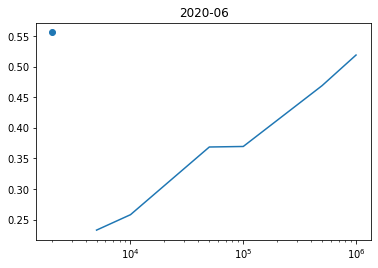

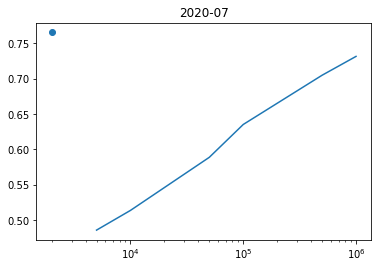

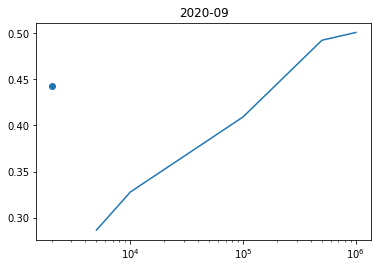

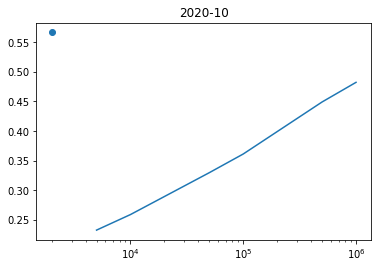

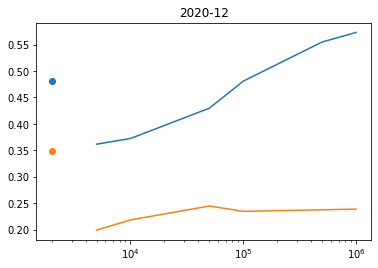

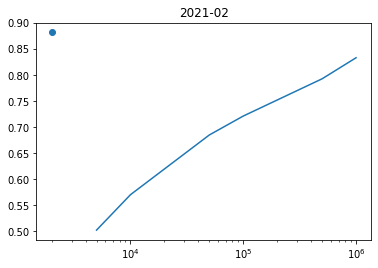

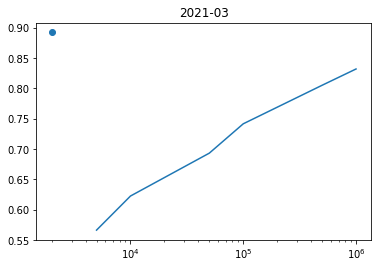

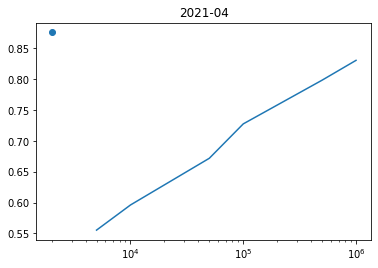

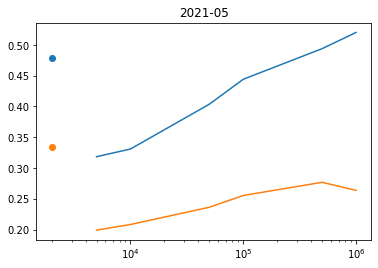

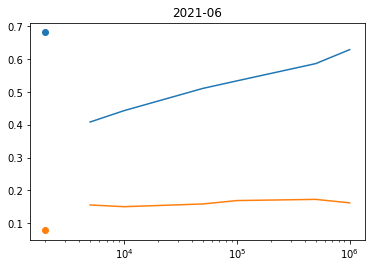

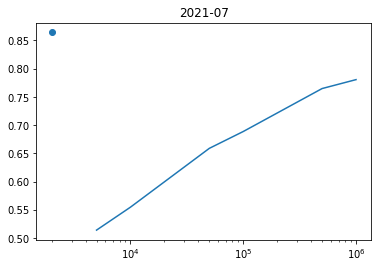

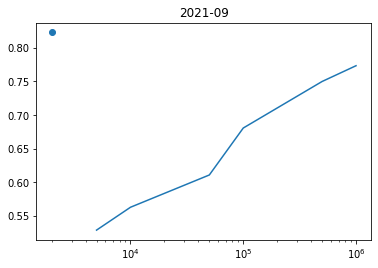

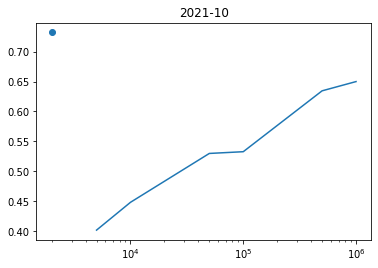

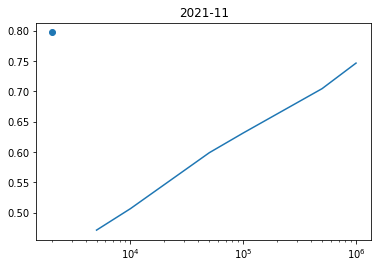

In [60]:
plot_freq_evolution()

---

In [11]:
def calculate_frequency_1(s, t1, growth_rate, t_end):
    dt = t_end - t1
    ex1 = growth_rate * s * dt
    ex2 = -growth_rate * t1
    b1 = np.exp(ex1)
    b2 = np.exp(ex2)
    b3 = b1 * b2
    return b3 / (b3 + 1 - b2)

def calculate_frequency_2(s1, t1, s2, t2, growth_rate, t_end):
    dt1 = t_end - t1
    dt2 = t_end - t2
    ex11 = growth_rate * s1 * dt1
    ex12 = growth_rate * s2 * dt2
    ex21 = -growth_rate * t1
    ex22 = -growth_rate * t2
    b1 = np.exp(ex11) * np.exp(ex21)
    b2 = np.exp(ex12) * np.exp(ex22)
    return b1 / (b1 + b2 + 1), b2 / (b1 + b2 + 1)

In [12]:
params = lambda x,date: x['United-Kingdom'][date]['parameters']

def plot_evolution(f, n = 31, freqs = None):
    fig, ax = plt.subplots(figsize=(16,5))
    all_figures.add(fig)
    x = np.linspace(0,n, 1000)
    y = np.array([f(i) for i in x])
    ax.plot(x, y)
    ax.grid(which="both")
    ax.set_yticks(np.linspace(0,1, 11))
    if freqs is not None:
        x_min = x[np.argmin(np.linalg.norm(y - np.array(freqs), axis=1)) if len(freqs) == 2 else np.argmin(np.abs(y - np.array(freqs)))]
        for fr in freqs:
            ax.scatter([x_min], [fr])
    return ax

<AxesSubplot:>

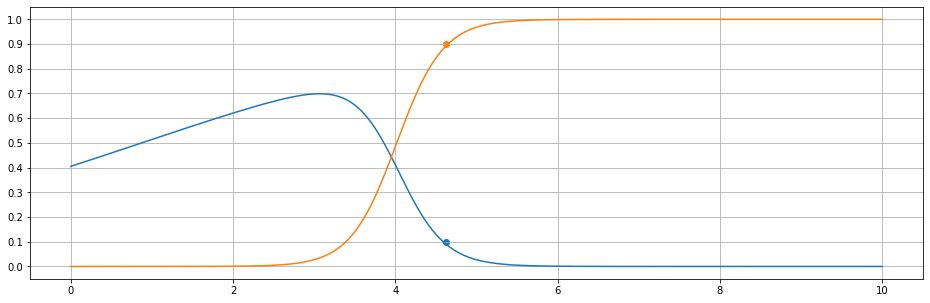

In [13]:
plot_evolution(
    f = lambda i:calculate_frequency_2(
        0.4, 
        0.25, 
        3.5, 
        2.8, 
        np.log(3), 
        i
    ),
    n = 10,
    freqs = [0.1, 0.9]
)

In [14]:
def get_parameters(dictionary, name):
    _, country, date, read_depth, n_mutations, _, _ = ("-".join(name.split("-")[:-1]) + "_" + name.split("-")[-1]).split("_")
    year, month = list(map(lambda x:int(x), date.split("-")))
    if country not in dictionary:
        dictionary[country] = dict()
    date_key = f"{year}-{month:02d}"
    # find which model to use (0,1,2 subclones)
    n_clones = find_which_model(name)
    # there's nothing interesting with no subclones
    if (n_clones == 0):
        return dictionary
    # read parameters
    parameters = get_inferred_parameters(name, n_clones)
    dictionary[country][date_key] = parameters
    return dictionary

In [15]:
parameter_files_01 = [
    # UK
    "m_United-Kingdom_2020-6_4774_115-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-7_2157_154-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-8_5185_223-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-9_9567_233-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-10_16288_200-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-11_20799_237-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-1_42335_150-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-2_19586_150-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-3_722_187-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-4_1090_231-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-5_3445_240-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-6_4438_131-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-7_6862_101-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-9_4463_115-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-10_4817_151-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-11_3674_167-filtered0.01_Nmax2000",
    # USA
    "m_USA_2020-8_2478_163-filtered0.01_Nmax2000",
    "m_USA_2020-9_2126_176-filtered0.01_Nmax2000",
    "m_USA_2020-10_2605_187-filtered0.01_Nmax2000",
    "m_USA_2020-11_5307_189-filtered0.01_Nmax2000",
    "m_USA_2020-12_10731_200-filtered0.01_Nmax2000",
    "m_USA_2021-1_15431_237-filtered0.01_Nmax2000",
    "m_USA_2021-2_20513_274-filtered0.01_Nmax2000",
    "m_USA_2021-3_44445_267-filtered0.01_Nmax2000",
    "m_USA_2021-4_66036_273-filtered0.01_Nmax2000",
    "m_USA_2021-5_32416_270-filtered0.01_Nmax2000",
    "m_USA_2021-6_12436_307-filtered0.01_Nmax2000",
    "m_USA_2021-7_8715_295-filtered0.01_Nmax2000",
    "m_USA_2021-8_3767_275-filtered0.01_Nmax2000",
    "m_USA_2021-9_5055_216-filtered0.01_Nmax2000",
    "m_USA_2021-10_6004_189-filtered0.01_Nmax2000",
    "m_USA_2021-11_89440_160-filtered0.01_Nmax2000",
    "m_USA_2021-12_82879_257-filtered0.01_Nmax2000"
]

parameter_files_001 = [
    # UK
    "m_United-Kingdom_2020-6_4774_1061-filtered0.001_Nmax2000",
    "m_United-Kingdom_2020-7_2157_1016-filtered0.001_Nmax2000",
    "m_United-Kingdom_2020-8_5185_992-filtered0.001_Nmax2000",
    "m_United-Kingdom_2020-9_9567_909-filtered0.001_Nmax2000",
    "m_United-Kingdom_2020-10_16288_1092-filtered0.001_Nmax2000",
    "m_United-Kingdom_2020-11_20799_1260-filtered0.001_Nmax2000",
    "m_United-Kingdom_2020-12_20282_1258-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-1_42335_1092-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-2_19586_1225-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-3_722_2043-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-4_1090_1201-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-5_3445_1299-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-6_4438_828-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-7_6862_982-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-8_3258_1372-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-9_4463_1662-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-10_4817_2118-filtered0.001_Nmax2000",
    "m_United-Kingdom_2021-11_3674_2300-filtered0.001_Nmax2000",
    # USA
    "m_USA_2020-7_2707_1444-filtered0.001_Nmax2000",
    "m_USA_2020-8_2478_1437-filtered0.001_Nmax2000",
    "m_USA_2020-9_2126_1448-filtered0.001_Nmax2000",
    "m_USA_2020-10_2605_1902-filtered0.001_Nmax2000",
    "m_USA_2020-11_5307_1967-filtered0.001_Nmax2000",
    "m_USA_2020-12_10731_2131-filtered0.001_Nmax2000",
    "m_USA_2021-1_15431_2166-filtered0.001_Nmax2000",
    "m_USA_2021-2_20513_2115-filtered0.001_Nmax2000",
    "m_USA_2021-3_44445_1769-filtered0.001_Nmax2000",
    "m_USA_2021-4_66036_1547-filtered0.001_Nmax2000",
    "m_USA_2021-5_32416_1738-filtered0.001_Nmax2000",
    "m_USA_2021-6_12436_2022-filtered0.001_Nmax2000",
    "m_USA_2021-7_8715_1781-filtered0.001_Nmax2000",
    "m_USA_2021-8_3767_1669-filtered0.001_Nmax2000",
    "m_USA_2021-9_5055_1615-filtered0.001_Nmax2000",
    "m_USA_2021-10_6004_1925-filtered0.001_Nmax2000",
    "m_USA_2021-11_89440_2031-filtered0.001_Nmax2000",
    "m_USA_2021-12_82879_1739-filtered0.001_Nmax2000"
]

In [16]:
parameter_data_01 = reduce(get_parameters, parameter_files_01, dict())
parameter_data_001 = reduce(get_parameters, parameter_files_001, dict())

In [237]:
pp(parameter_data_01)

{'USA': {'2020-10': {'clonalmutations': 104,
                     'frequency': [0.4655, 0.262],
                     'nclones': 2,
                     's': [0.290496389678564, 0.2084070229419625],
                     'tevent': [2.936675206838951, 2.931780422213032],
                     'μ': 1.5835053358271478},
         '2020-11': {'clonalmutations': 98,
                     'frequency': 0.4455,
                     'nclones': 1,
                     's': [0.23147074394309364],
                     'tevent': [3.7398805883966837],
                     'μ': 1.933099409047526},
         '2020-12': {'clonalmutations': 101,
                     'frequency': 0.3755,
                     'nclones': 1,
                     's': [0.2084538146438588],
                     'tevent': [3.921174258829047],
                     'μ': 2.47792270758052},
         '2020-8': {'clonalmutations': 81,
                    'frequency': [0.4915, 0.2135],
                    'nclones': 2,
                    

In [17]:
def plot_all_evolutions(data):
    for country, country_data in data.items():
        for date, parameters in sorted(country_data.items(), key=lambda x:dt.date(*list(map(lambda y:int(y), x[0].split("-"))), 1)):
            if parameters["nclones"] == 1:
                ax = plot_evolution(
                    f = lambda i:calculate_frequency_1(
                        parameters['s'][0], 
                        parameters['tevent'][0], 
                        np.log(3), 
                        i
                    ),
                    freqs = [parameters["frequency"]]
                )
            elif parameters["nclones"] == 2:
                ax = plot_evolution(
                    f = lambda i:calculate_frequency_2(
                        parameters['s'][0], 
                        parameters['s'][1], 
                        parameters['tevent'][0], 
                        parameters['tevent'][1], 
                        np.log(3), 
                        i
                    ),
                    n = 10,
                    freqs = parameters["frequency"][::-1]
                )
            ax.set_title(f"{country}: {date}")

C:\Users\KONRAD~1\AppData\Local\Temp/ipykernel_12268/1683256353.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16,5))


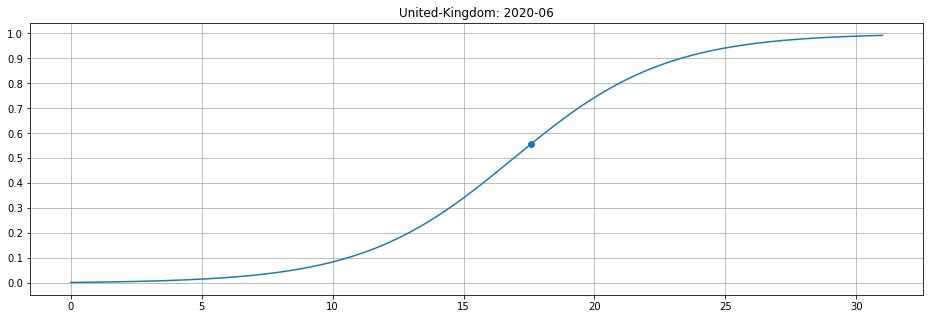

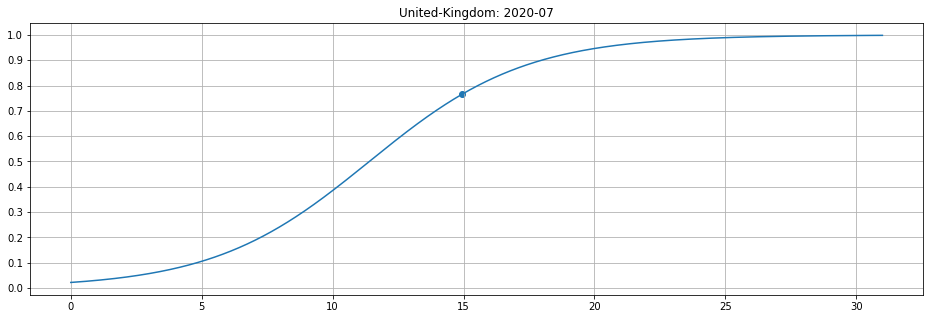

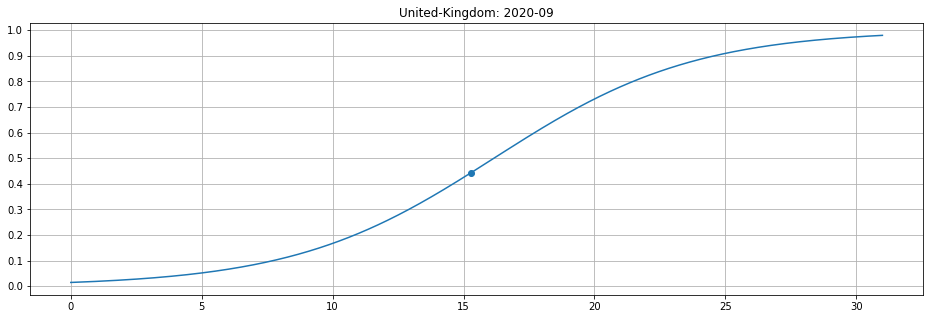

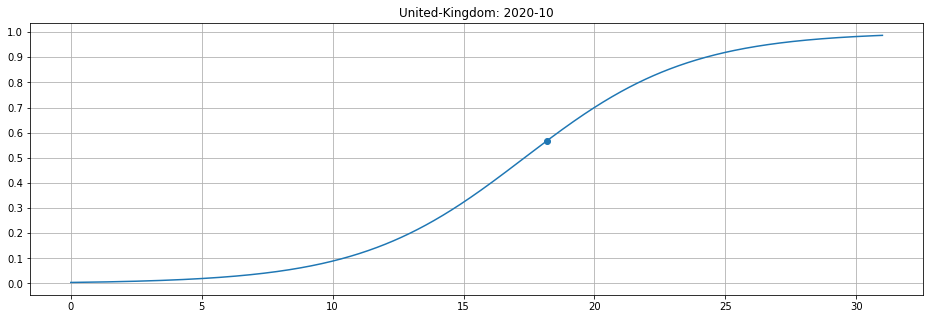

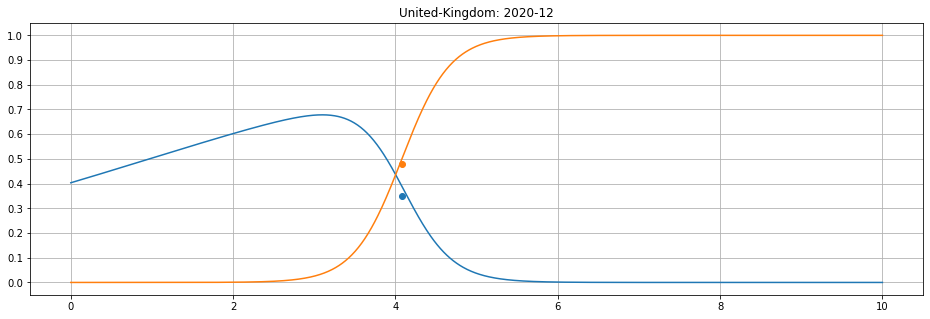

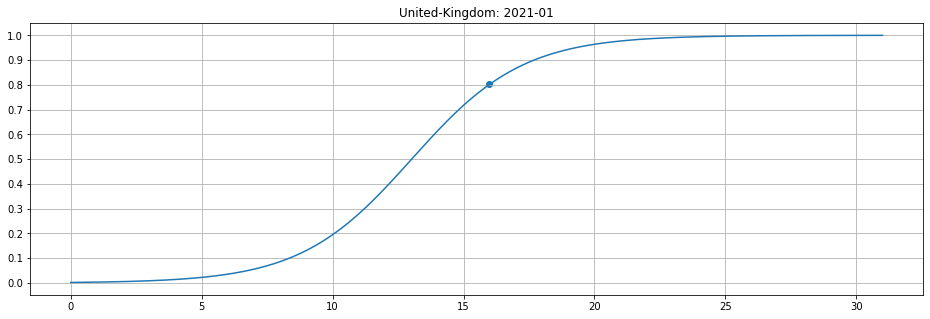

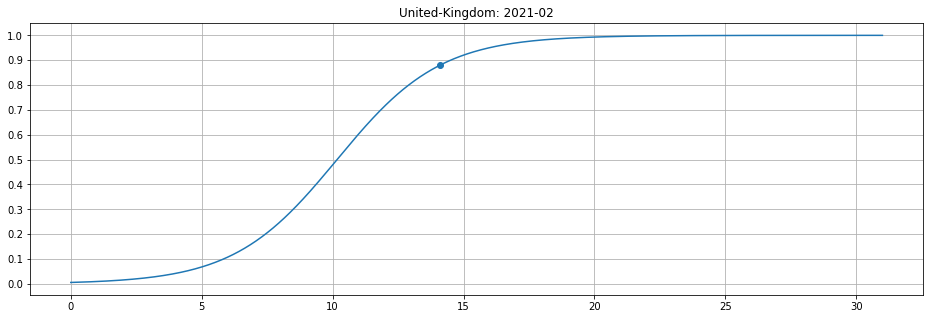

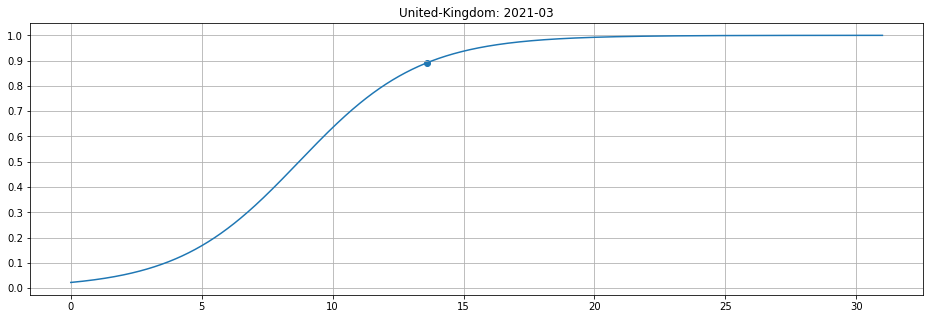

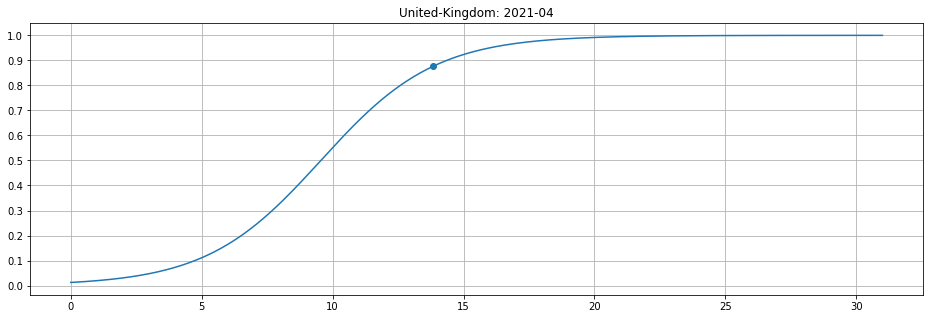

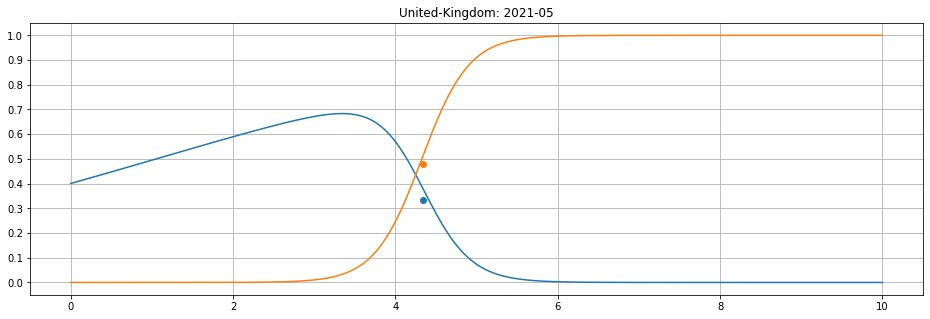

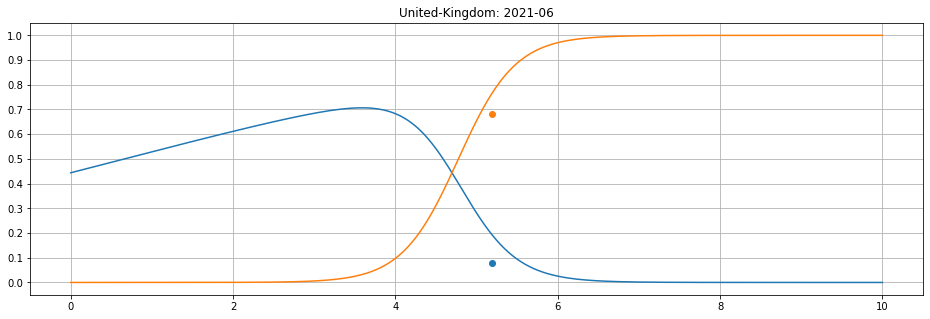

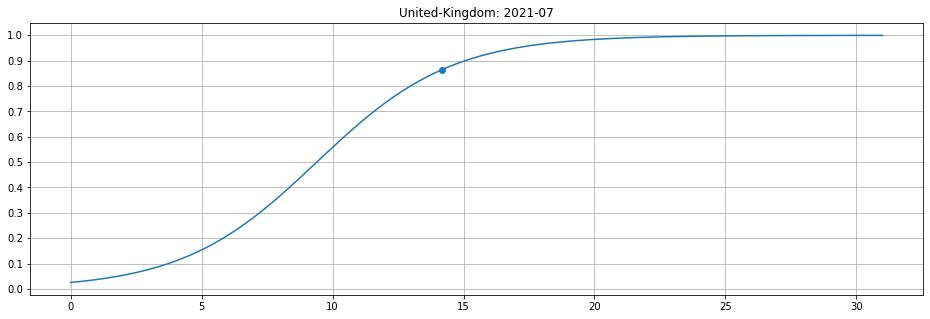

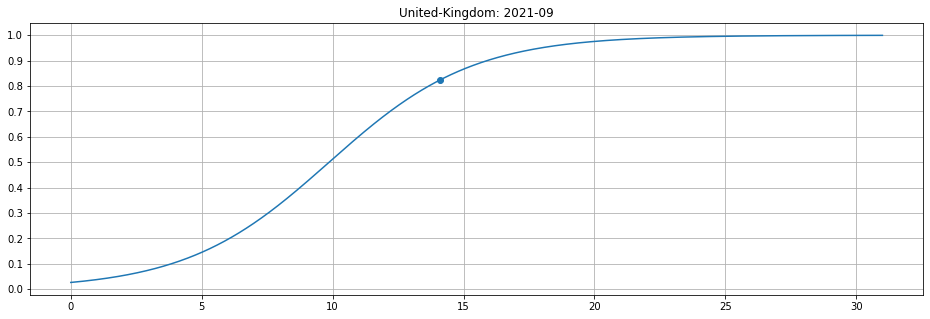

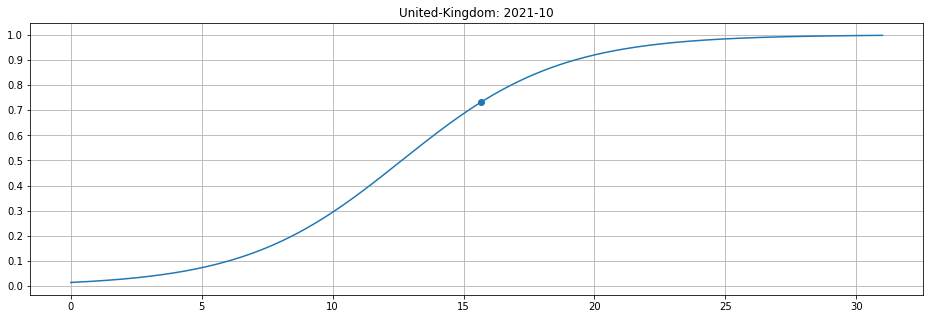

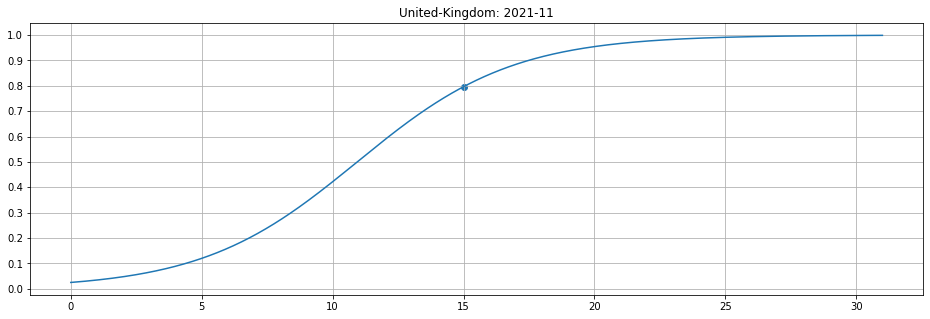

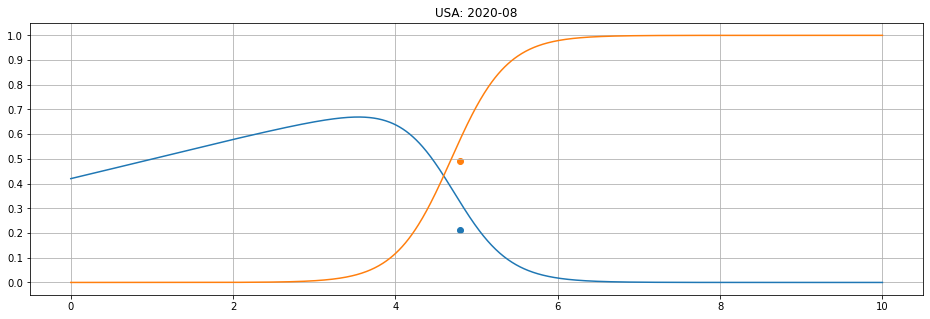

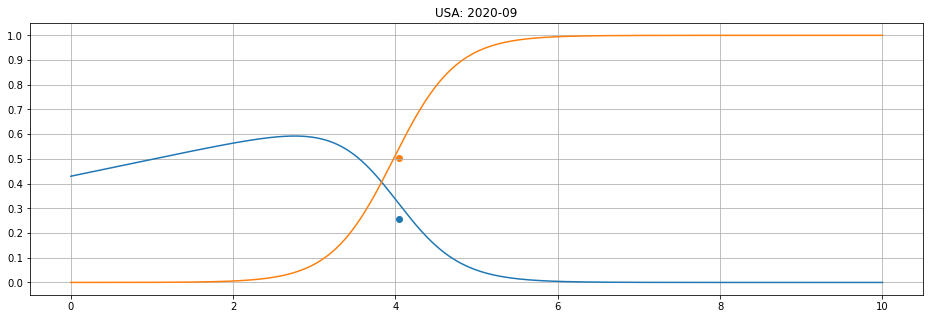

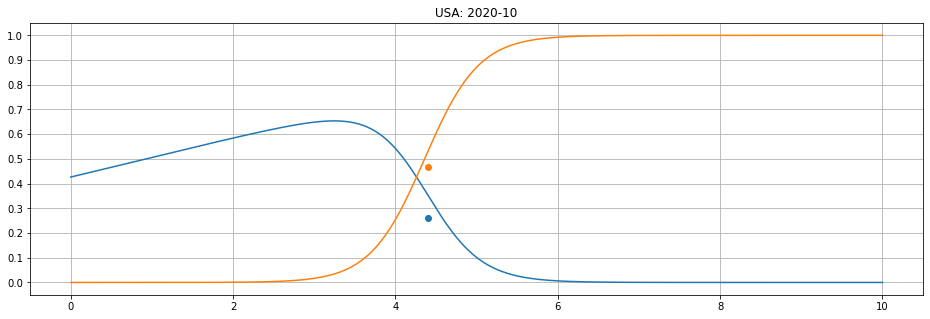

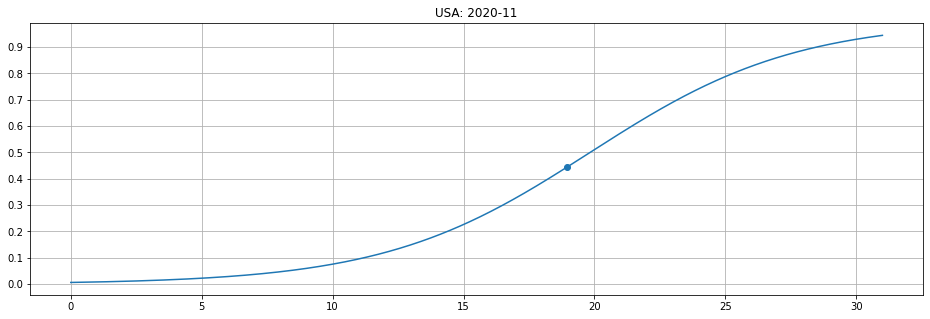

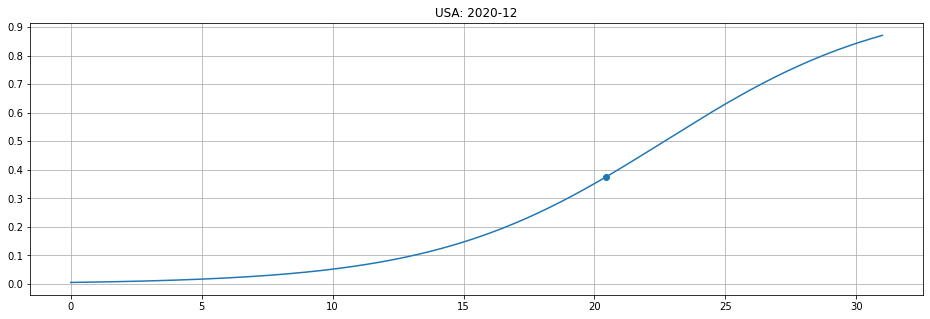

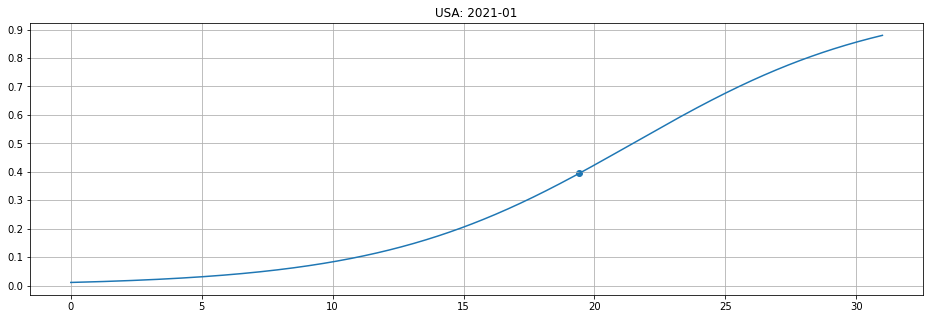

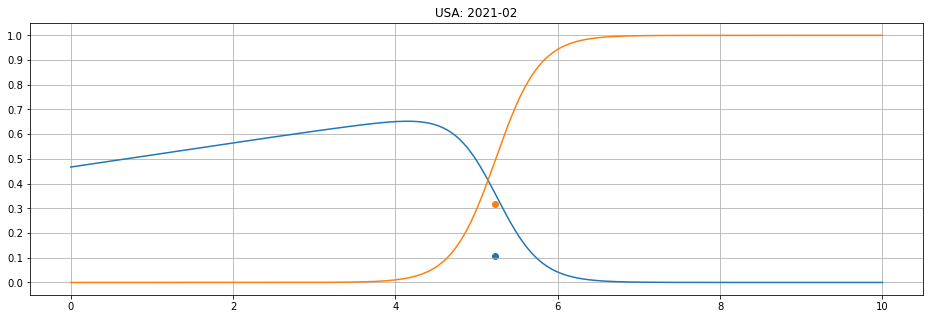

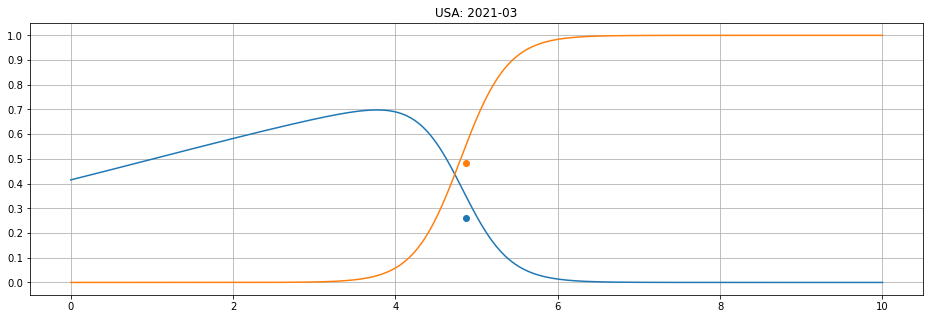

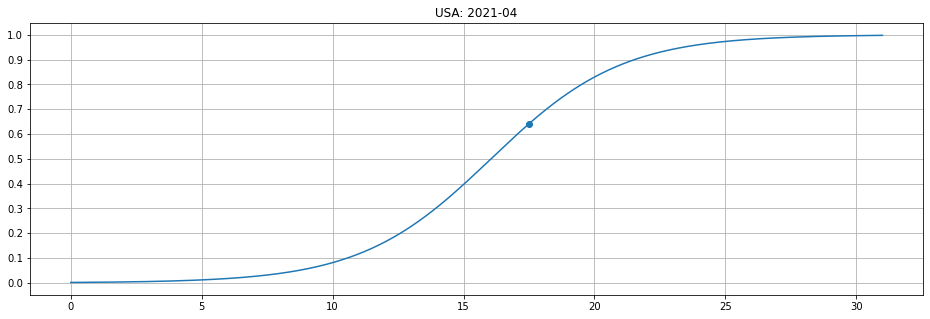

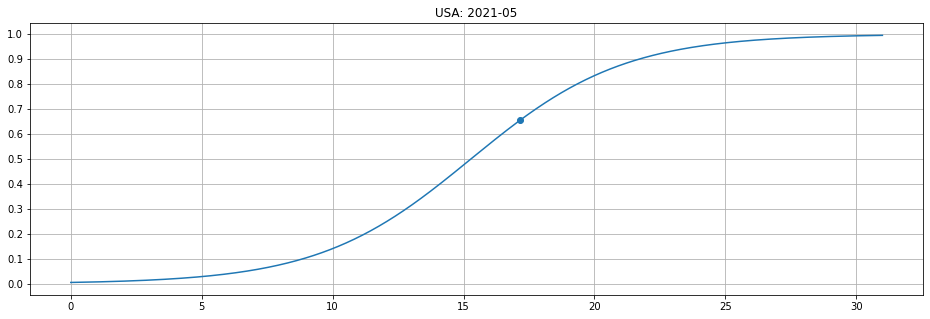

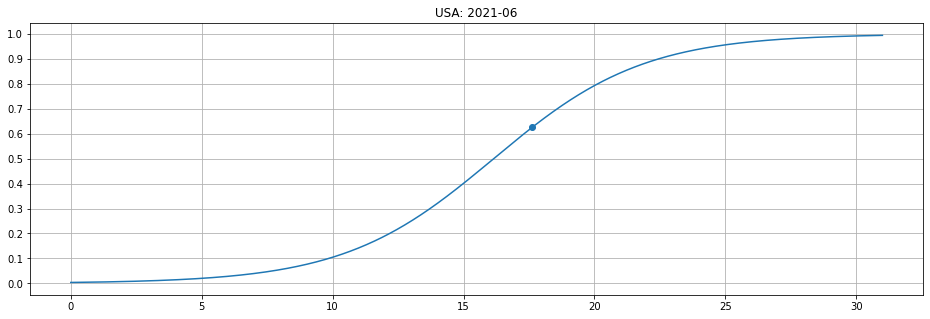

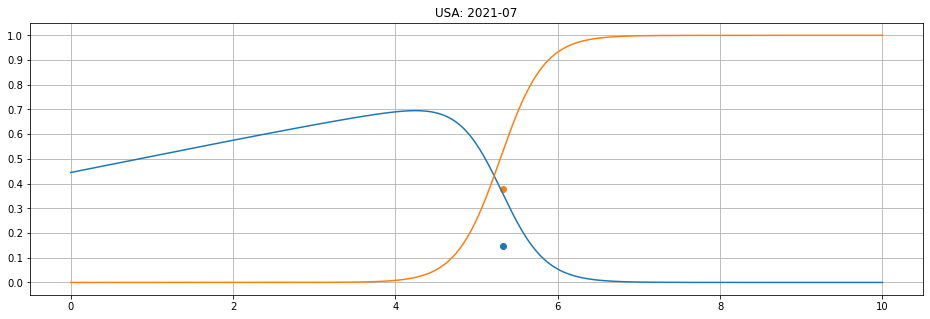

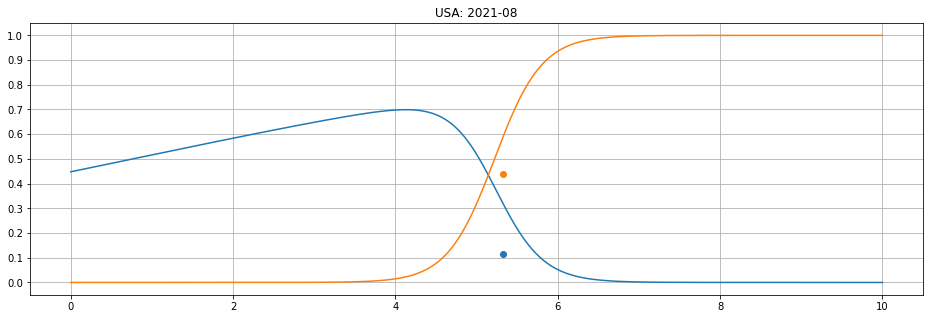

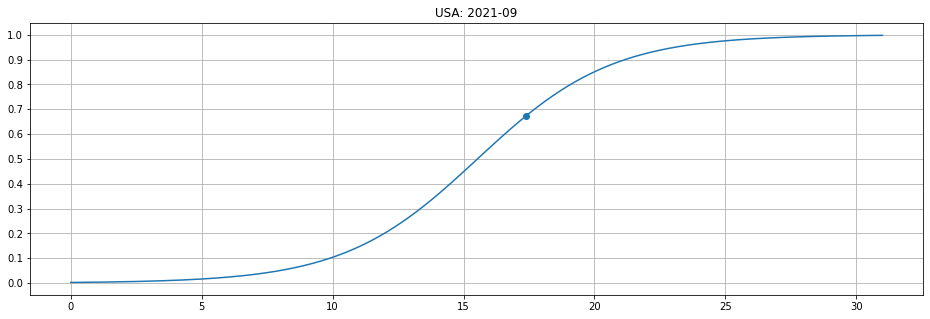

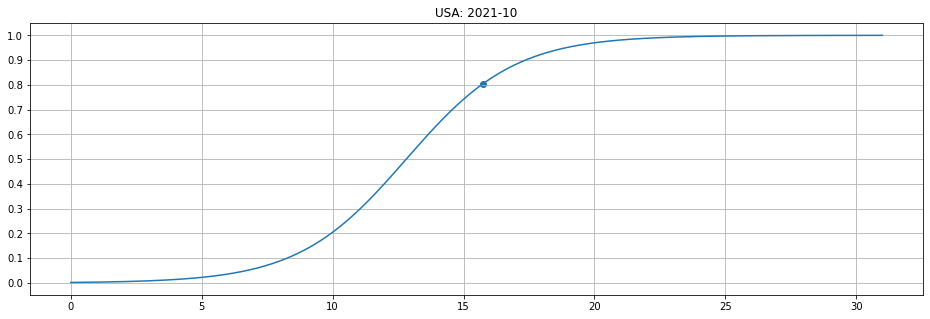

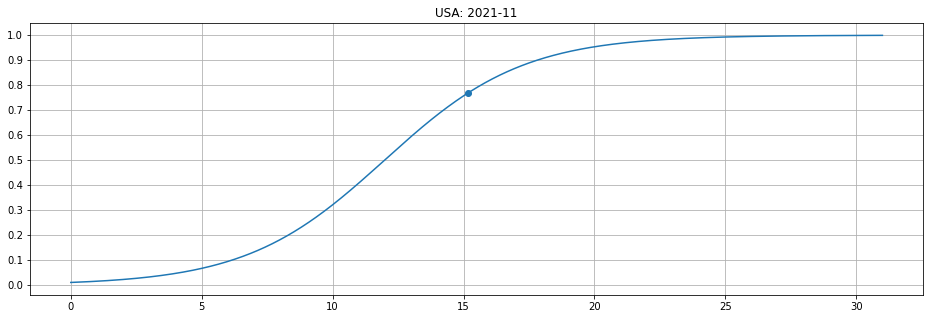

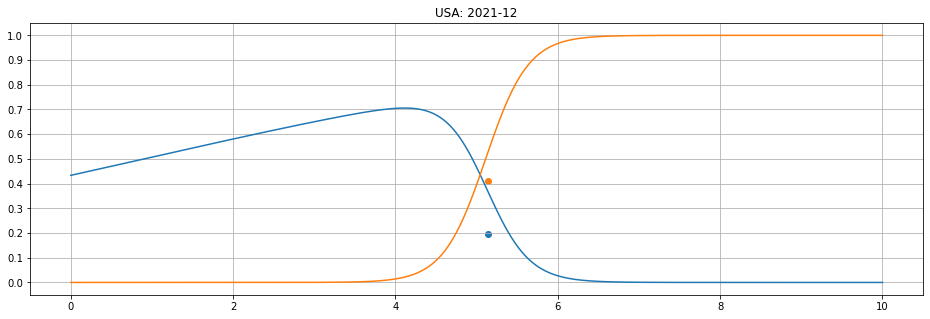

In [17]:
plot_all_evolutions(parameter_data_01)

In [20]:
all_figures.clear_figures()

---

In [18]:
base_path_covid = r"C:\Users\Konrad Grudzinski\OneDrive - University of Glasgow\Computing\4th Year\Individual Project\Source\covid19"

In [19]:
labels = [f"{year}-{month:02}" for year in [2020,2021] for month in range(1,13)] + ["2022-01", "2022-02"]
label_positions = {l:i for i,l in enumerate(labels)}

In [20]:
variant_names = [
    '20I (Alpha, V1)',
    '20H (Beta, V2)',
    '20J (Gamma, V3)',
    '21A (Delta)',
    '21I (Delta)',
    '21J (Delta)',
    '21K (Omicron)',
    '21L (Omicron)',
    '21B (Kappa)',
    '21D (Eta)',
    '21F (Iota)',
    '21G (Lambda)',
    '21H (Mu)',
    '20E (EU1)',
    '21C (Epsilon)',
    '20B/S:732A',
    '20A/S:126A',
    '20A/S:439K',
    'S:677H.Robin1',
    'S:677P.Pelican',
    '20A.EU2',
    '20A/S:98F',
    '20C/S:80Y',
    '20B/S:1122L',
    '20B/S:626S'
]
variant_colors = [
    # alpha
    "royalblue",
    # beta
    "violet",
    # gamma
    "teal",
    # delta
    "lightsalmon",
    "tomato",
    "salmon",
    # omicron
    "lightpink",
    "pink",
    # kappa
    "navajowhite",
    # eta
    "blanchedalmond",
    # iota
    "moccasin",
    # lambda
    "wheat",
    # mu
    "lemonchiffon",
    # EU1
    "gold",
    # epsilon
    "bisque",
    # other
    "lightyellow",
    "beige",
    "cornsilk",
    "khaki",
    "palegoldenrod",
    "peachpuff",
    "mistyrose",
    "paleturquoise",
    "lightcyan",
    "snow",
    "linen",
    "lavenderblush"
]
variant_color_mapping = {name:color for name,color in zip(variant_names, variant_colors)}

In [21]:
with open(base_path_covid + "\EUClusters_data.json", "r") as f:
    case_counts = json.load(f)
cases = {key.replace(" ", "-"):values for key, values in case_counts["countries"].items()}

In [22]:
def get_freqs(case_data, country):
    cases = case_data[country].copy()
    week_mapping = dict()
    total_sequence_counts = np.array(cases.pop("total_sequences"))
    for i, week in enumerate(cases.pop("week")):
        week_mapping[i] = week[:7] # extract year & month (yyyy-mm)
    variants = {month:{variant:0 for variant in cases.keys()} for month in week_mapping.values()}
    for i, count in enumerate(total_sequence_counts):
        month = week_mapping[i]
        variants[month]["count"] = variants[month].get("count", 0) + count
    for variant, counts in cases.items():
        for i, count in enumerate(counts):
            month = week_mapping[i]
            variants[month][variant] += count
    freqs = dict()
    for month, values in variants.items():
        total_count = values.pop("count")
        frequencies = {variant:var_count/total_count for variant, var_count in values.items()}
        freqs[month] = frequencies
    return freqs

In [23]:
def plot_variant_fraction(country_freqs, ax, stacked = False):
    colors = ["fuchsia", "r", "darkblue"]
    mutations = [f"{i} subclones" for i in range(3)]
    variant_names = list(country_freqs[list(country_freqs.keys())[0]].keys())
    fractions = np.array(list(
        map(lambda x:np.array(list(x[1].values())), sorted(country_freqs.items(), key = lambda x:x[0]))
    ))
    x_f = np.array(sorted(map(lambda f:label_positions[f], country_freqs.keys()))) + 1
    colors = [variant_color_mapping[n] for n in variant_names if n in variant_color_mapping]
    if not stacked:
        for i in range(fractions.shape[1]):
            y_f = fractions.T[i]
            ax.plot(x_f, y_f, label=variant_names[i], color=colors[i])
    else:
        ax.stackplot(x_f,
                fractions.T,
                labels=variant_names,
                colors=colors,
                alpha=0.75)
        
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlim(0,len(labels)-1)
    legend = ax.legend(loc="upper left")
    for line in legend.get_lines():
        line.set_linewidth(8)

In [24]:
def single_plot(ax, country_freqs, parameter_data, country, date, vertical_lines = False, stacked = False):
    country_data = parameter_data[country][date]
    b = 3
    if country_data["nclones"] == 2:
        x = np.linspace(0, 10, 1000)
        f = lambda i:calculate_frequency_2(
            country_data['s'][0], 
            country_data['s'][1], 
            country_data['tevent'][0], 
            country_data['tevent'][1], 
            np.log(b), 
            i
        )
        y = np.array([f(i) for i in x])
    elif country_data["nclones"] == 1:
        x = np.linspace(0, 30, 1000)
        f = lambda i:calculate_frequency_1(
            country_data['s'][0], 
            country_data['tevent'][0], 
            np.log(b), 
            i
        )
        y = np.array([f(i) for i in x])
        x /= b
    else:
        return
    freqs = (lambda fr:([fr] if type(fr) == np.float64 or type(fr) == float else fr))(country_data["frequency"])
    x_min = x[np.argmin(np.abs(y[:,1] - freqs[0])) if len(freqs) == 2 else np.argmin(np.abs(y - np.array(freqs)))]
    dx = label_positions[date] + 0.5 - x_min
    x += dx
    if country_data["nclones"] == 2:
        ax.plot(x, y[:,0], color="gray")
        ax.plot(x, y[:,1], color="black")
    else:
        ax.plot(x, y, color="black")
    for i,fr in enumerate(freqs):
        ax.scatter([label_positions[date] + 0.5], fr, color=["black", "gray"][i])
    
    if vertical_lines:
        for i in np.arange(len(labels)):
            ax.axvline(i, color="gray", linestyle=["--", "-."][i%2], alpha=0.3)
    
    plot_variant_fraction(country_freqs, ax, stacked)
    ax.set_title(f"{date}")

def plot_variant_fractions_and_predictions(cases, parameter_data, country, date, vertical_lines = False, stacked = False, title = None):
    country_freqs = get_freqs(cases, country)
    if type(date) == list:
        date = list(filter(lambda d:d in parameter_data[country], date))
        n = len(date)
        if n == 0:
            return
        columns = 2
        rows = (n+columns-1)//columns
        fig, axes = plt.subplots(rows, columns, figsize=(32, 9*rows))
        if rows == 1:
            axes = [axes]
        all_figures.add(fig)
        for i,d in enumerate(date):
            if d not in parameter_data[country]:
                axes[i//columns][i%columns].set_visible(False)
                continue
            single_plot(axes[i//columns][i%columns], country_freqs, parameter_data, country, d, vertical_lines, stacked)
    else:
        country_data = parameter_data[country][date]
        fig, ax = plt.subplots(figsize=(16,8), dpi=200)
        all_figures.add(fig)
        single_plot(ax, country_freqs, parameter_data, country, date, vertical_lines, stacked)

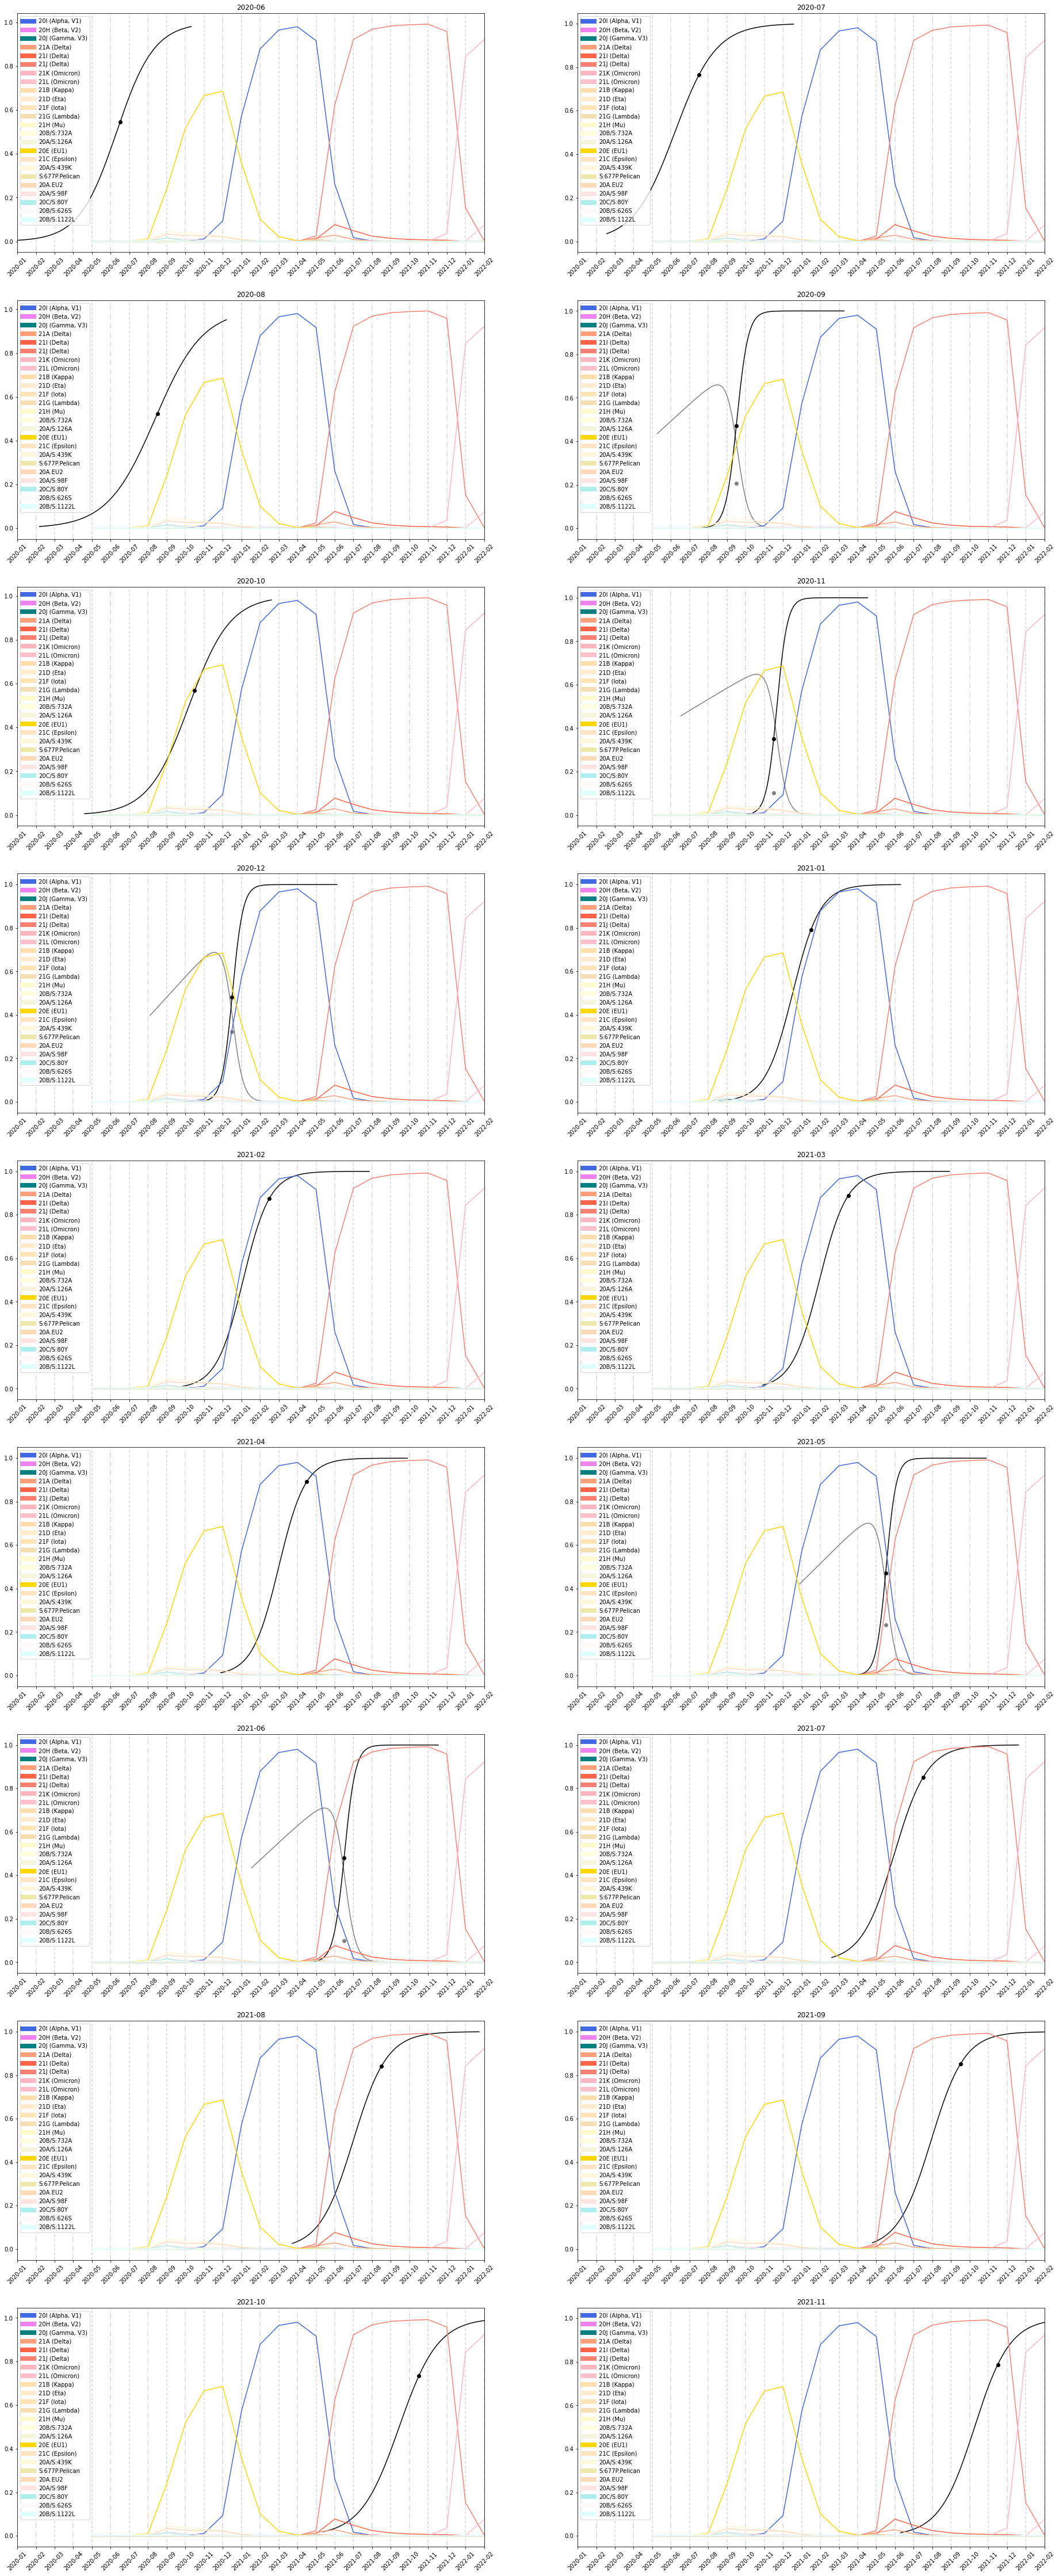

In [ ]:
plot_variant_fractions_and_predictions(cases, parameter_data_001, "United-Kingdom", [f"2020-{i:02d}" for i in range(6, 13)] + [f"2021-{i:02d}" for i in range(1, 12)], True, title="Spread predictions, United Kingdom")

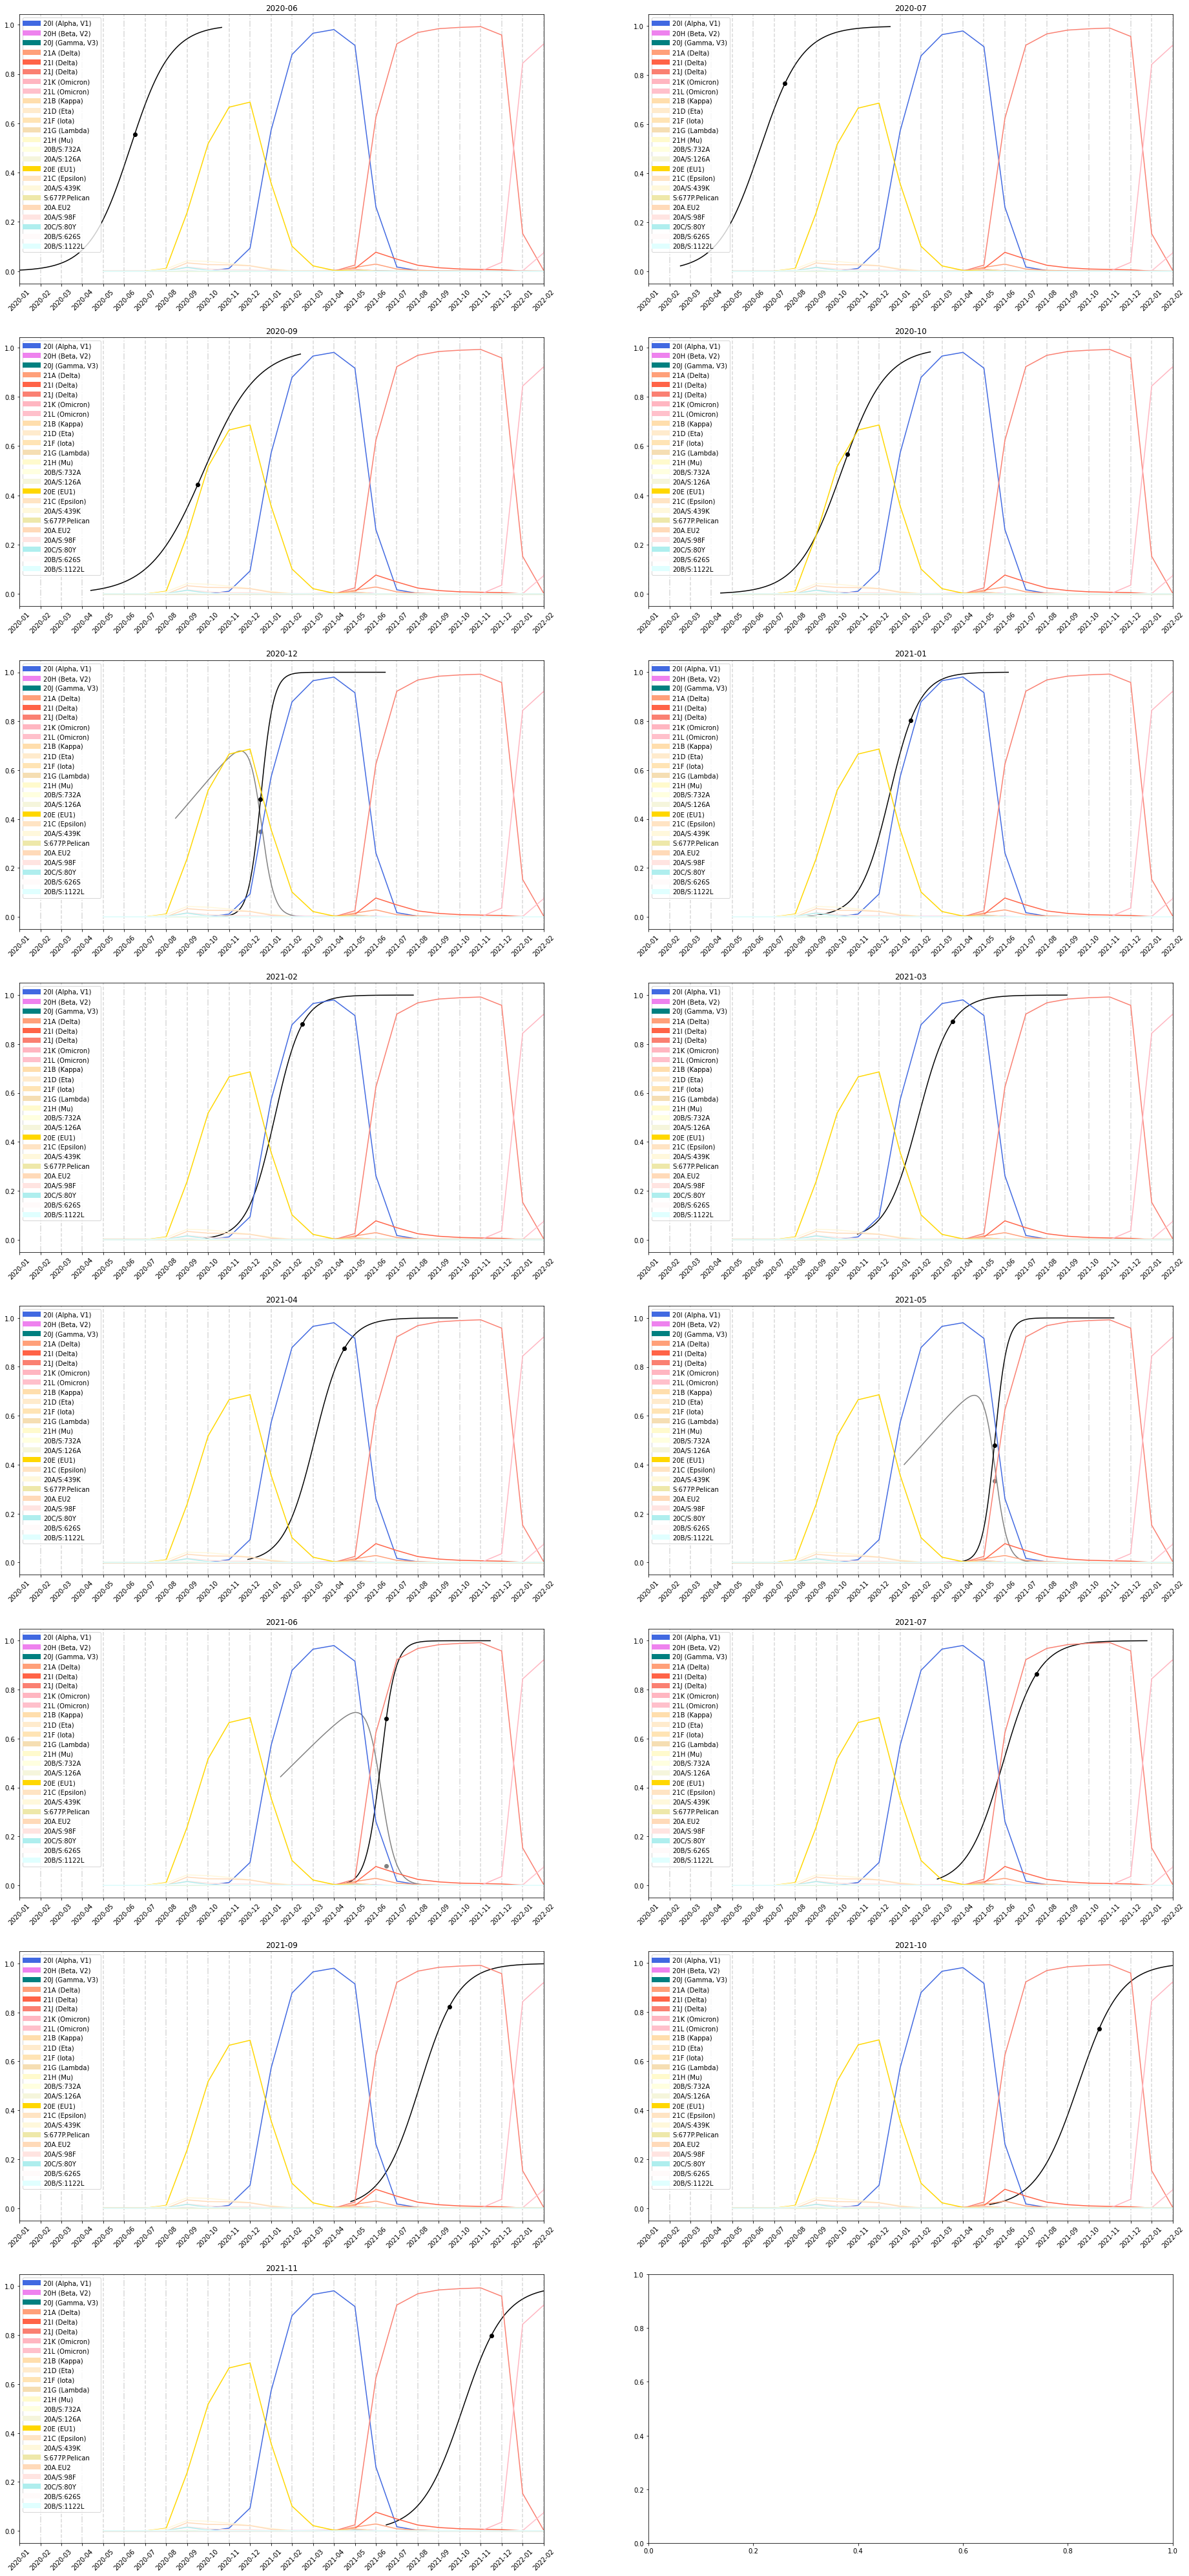

In [36]:
plot_variant_fractions_and_predictions(cases, parameter_data_01, "United-Kingdom", [f"2020-{i:02d}" for i in range(6, 13)] + [f"2021-{i:02d}" for i in range(1, 12)], True, title="Spread predictions, United Kingdom")

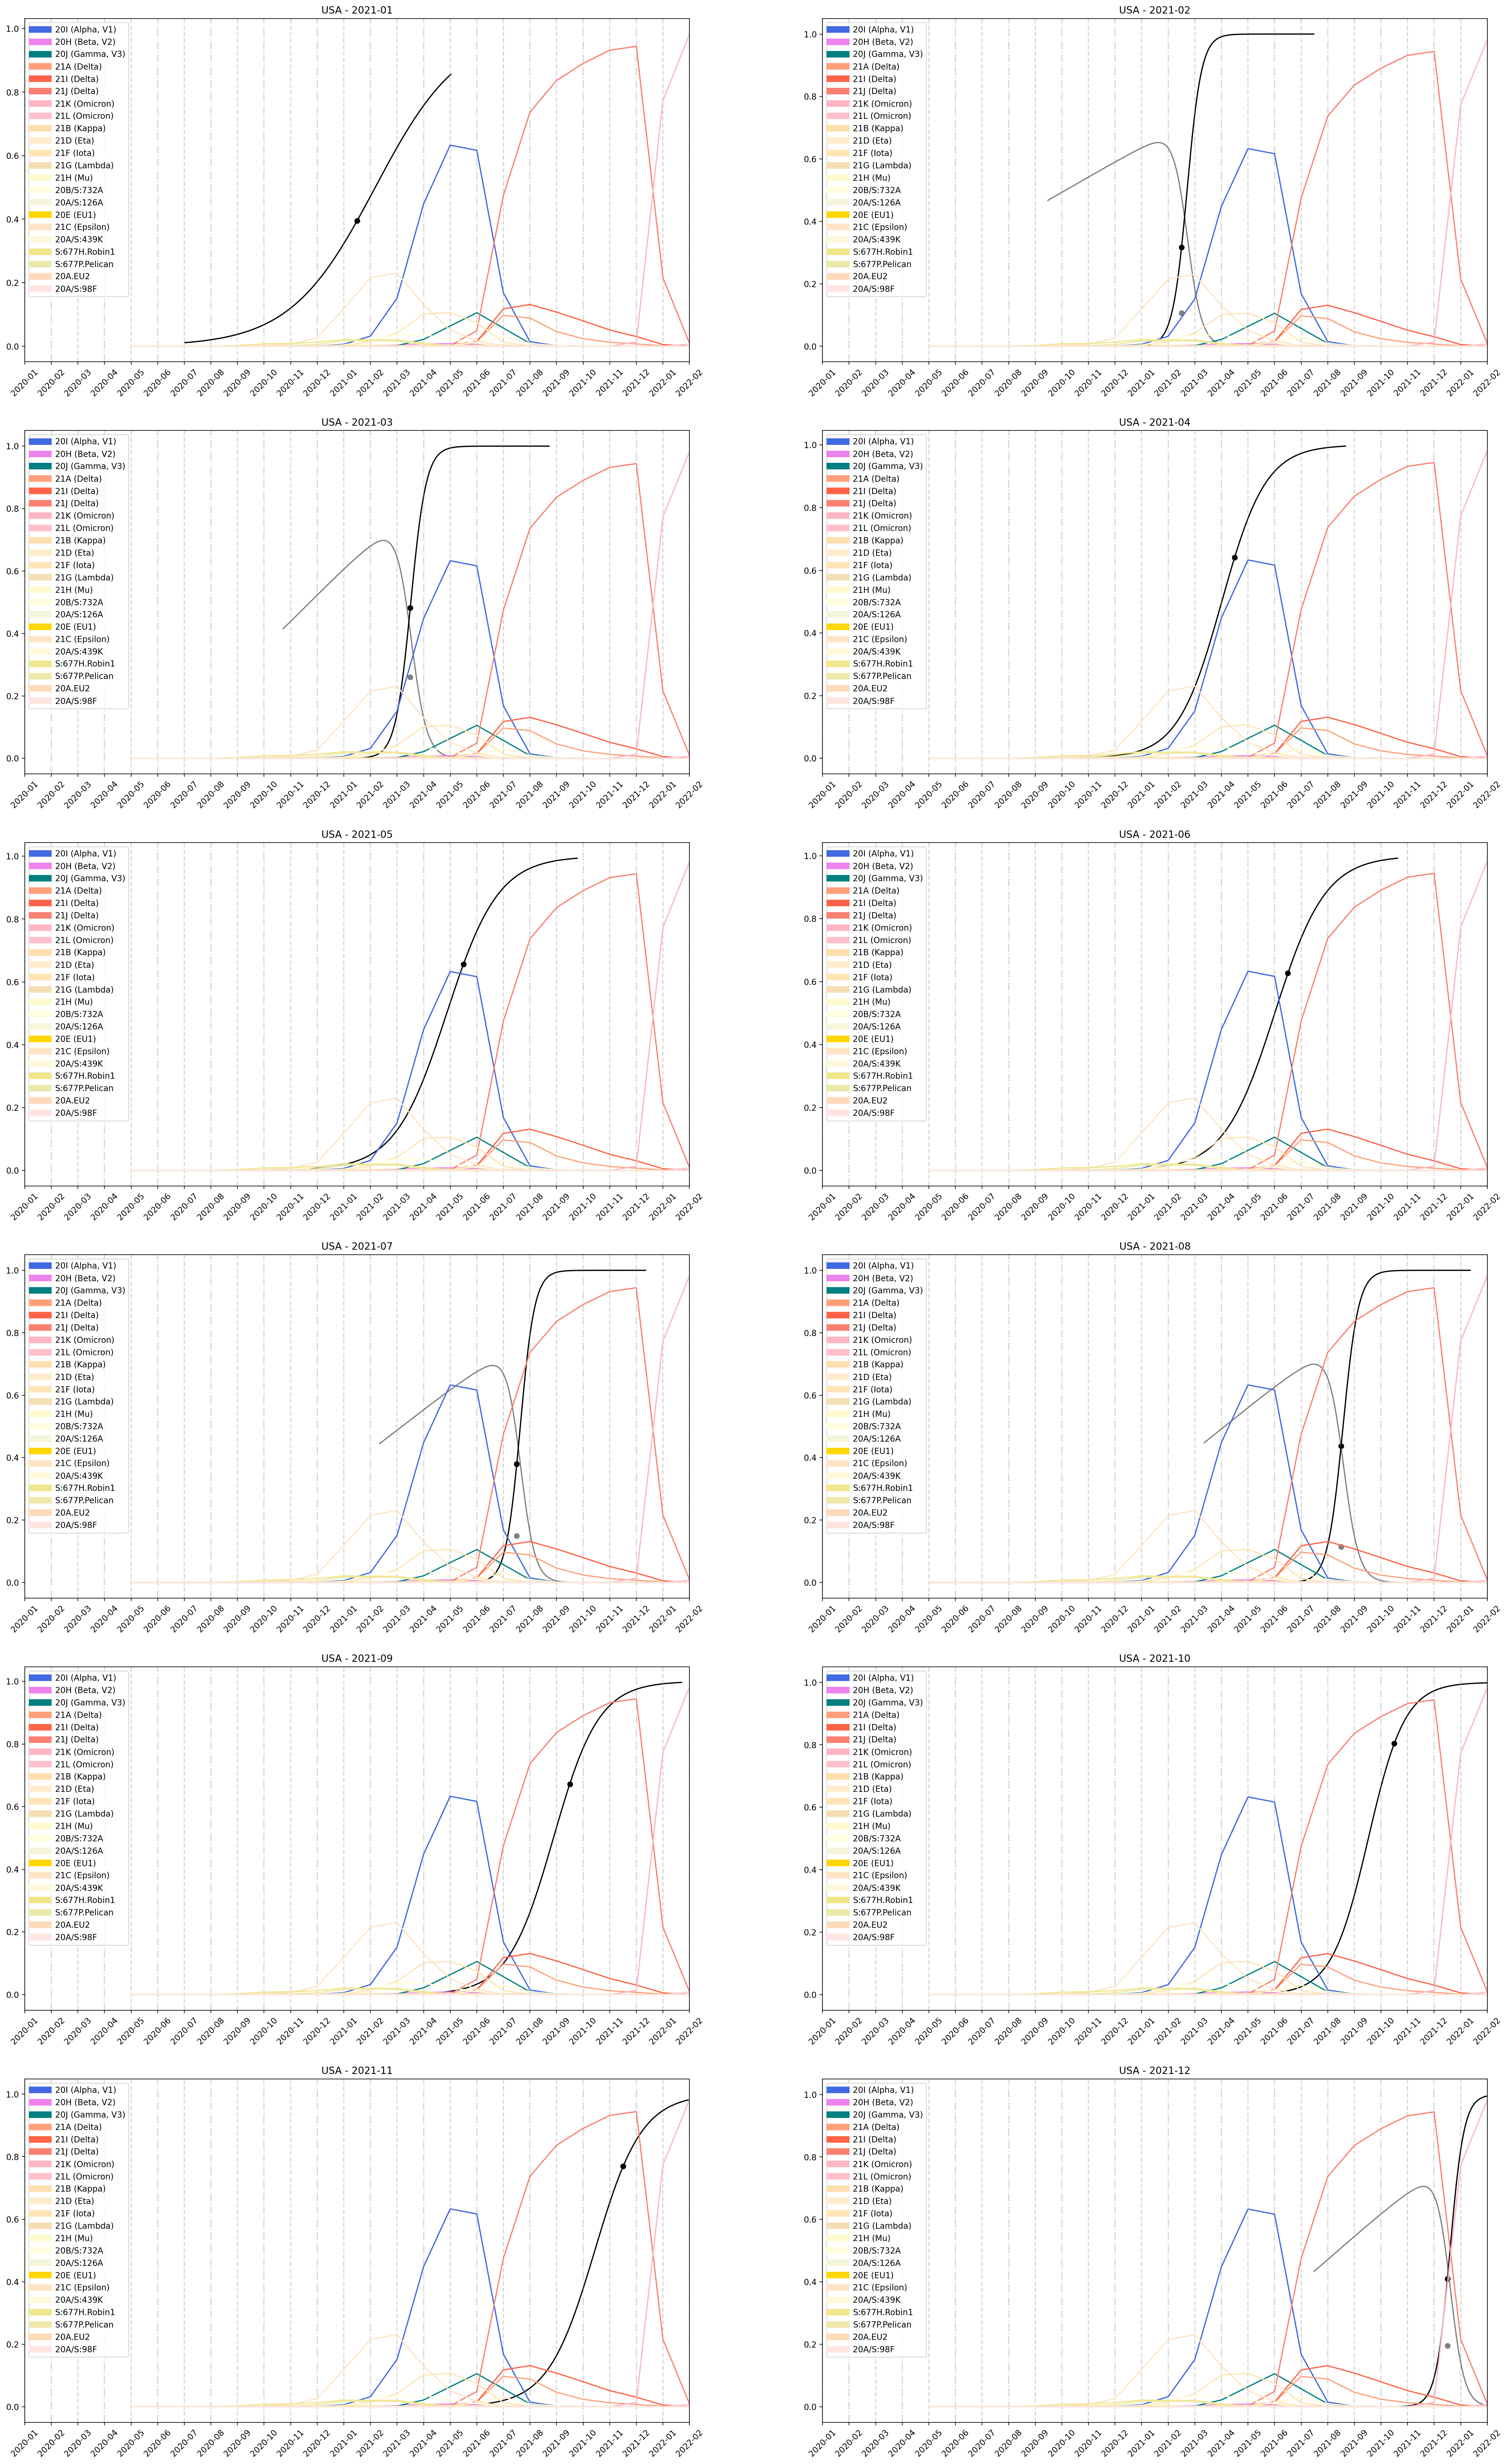

In [30]:
plot_variant_fractions_and_predictions(cases, parameter_data_01, "USA", [f"2021-{i:02d}" for i in range(1, 13)], vertical_lines = True, stacked = False)

---

In [165]:
def plot_predicted_frequencies(cases, parameter_data, country, vertical_lines = False, stacked = False): # parameter data for single country
    country_freqs = get_freqs(cases, country)
    country_data = parameter_data[country]
    data_sorted = sorted(country_data.items(), key=lambda x:dt.date(*list(map(lambda y:int(y), x[0].split("-"))), 1))
    frequencies_sorted = [(date, value["frequency"] if type(value["frequency"]) == list else [value["frequency"]]) for date, value in data_sorted]
    fig, ax = plt.subplots(figsize=(16,8), dpi=200)
    all_figures.add(fig)
    for date, freqs in frequencies_sorted:
        for f in freqs:
            ax.scatter([label_positions[date]+0.5], [f], color="black")
    if vertical_lines:
        for i in np.arange(len(labels)):
            ax.axvline(i, color="gray", linestyle=["--", "-."][i%2], alpha=0.3)
    plot_variant_fraction(country_freqs, ax, stacked)
    ax.set_title(f"{country}")

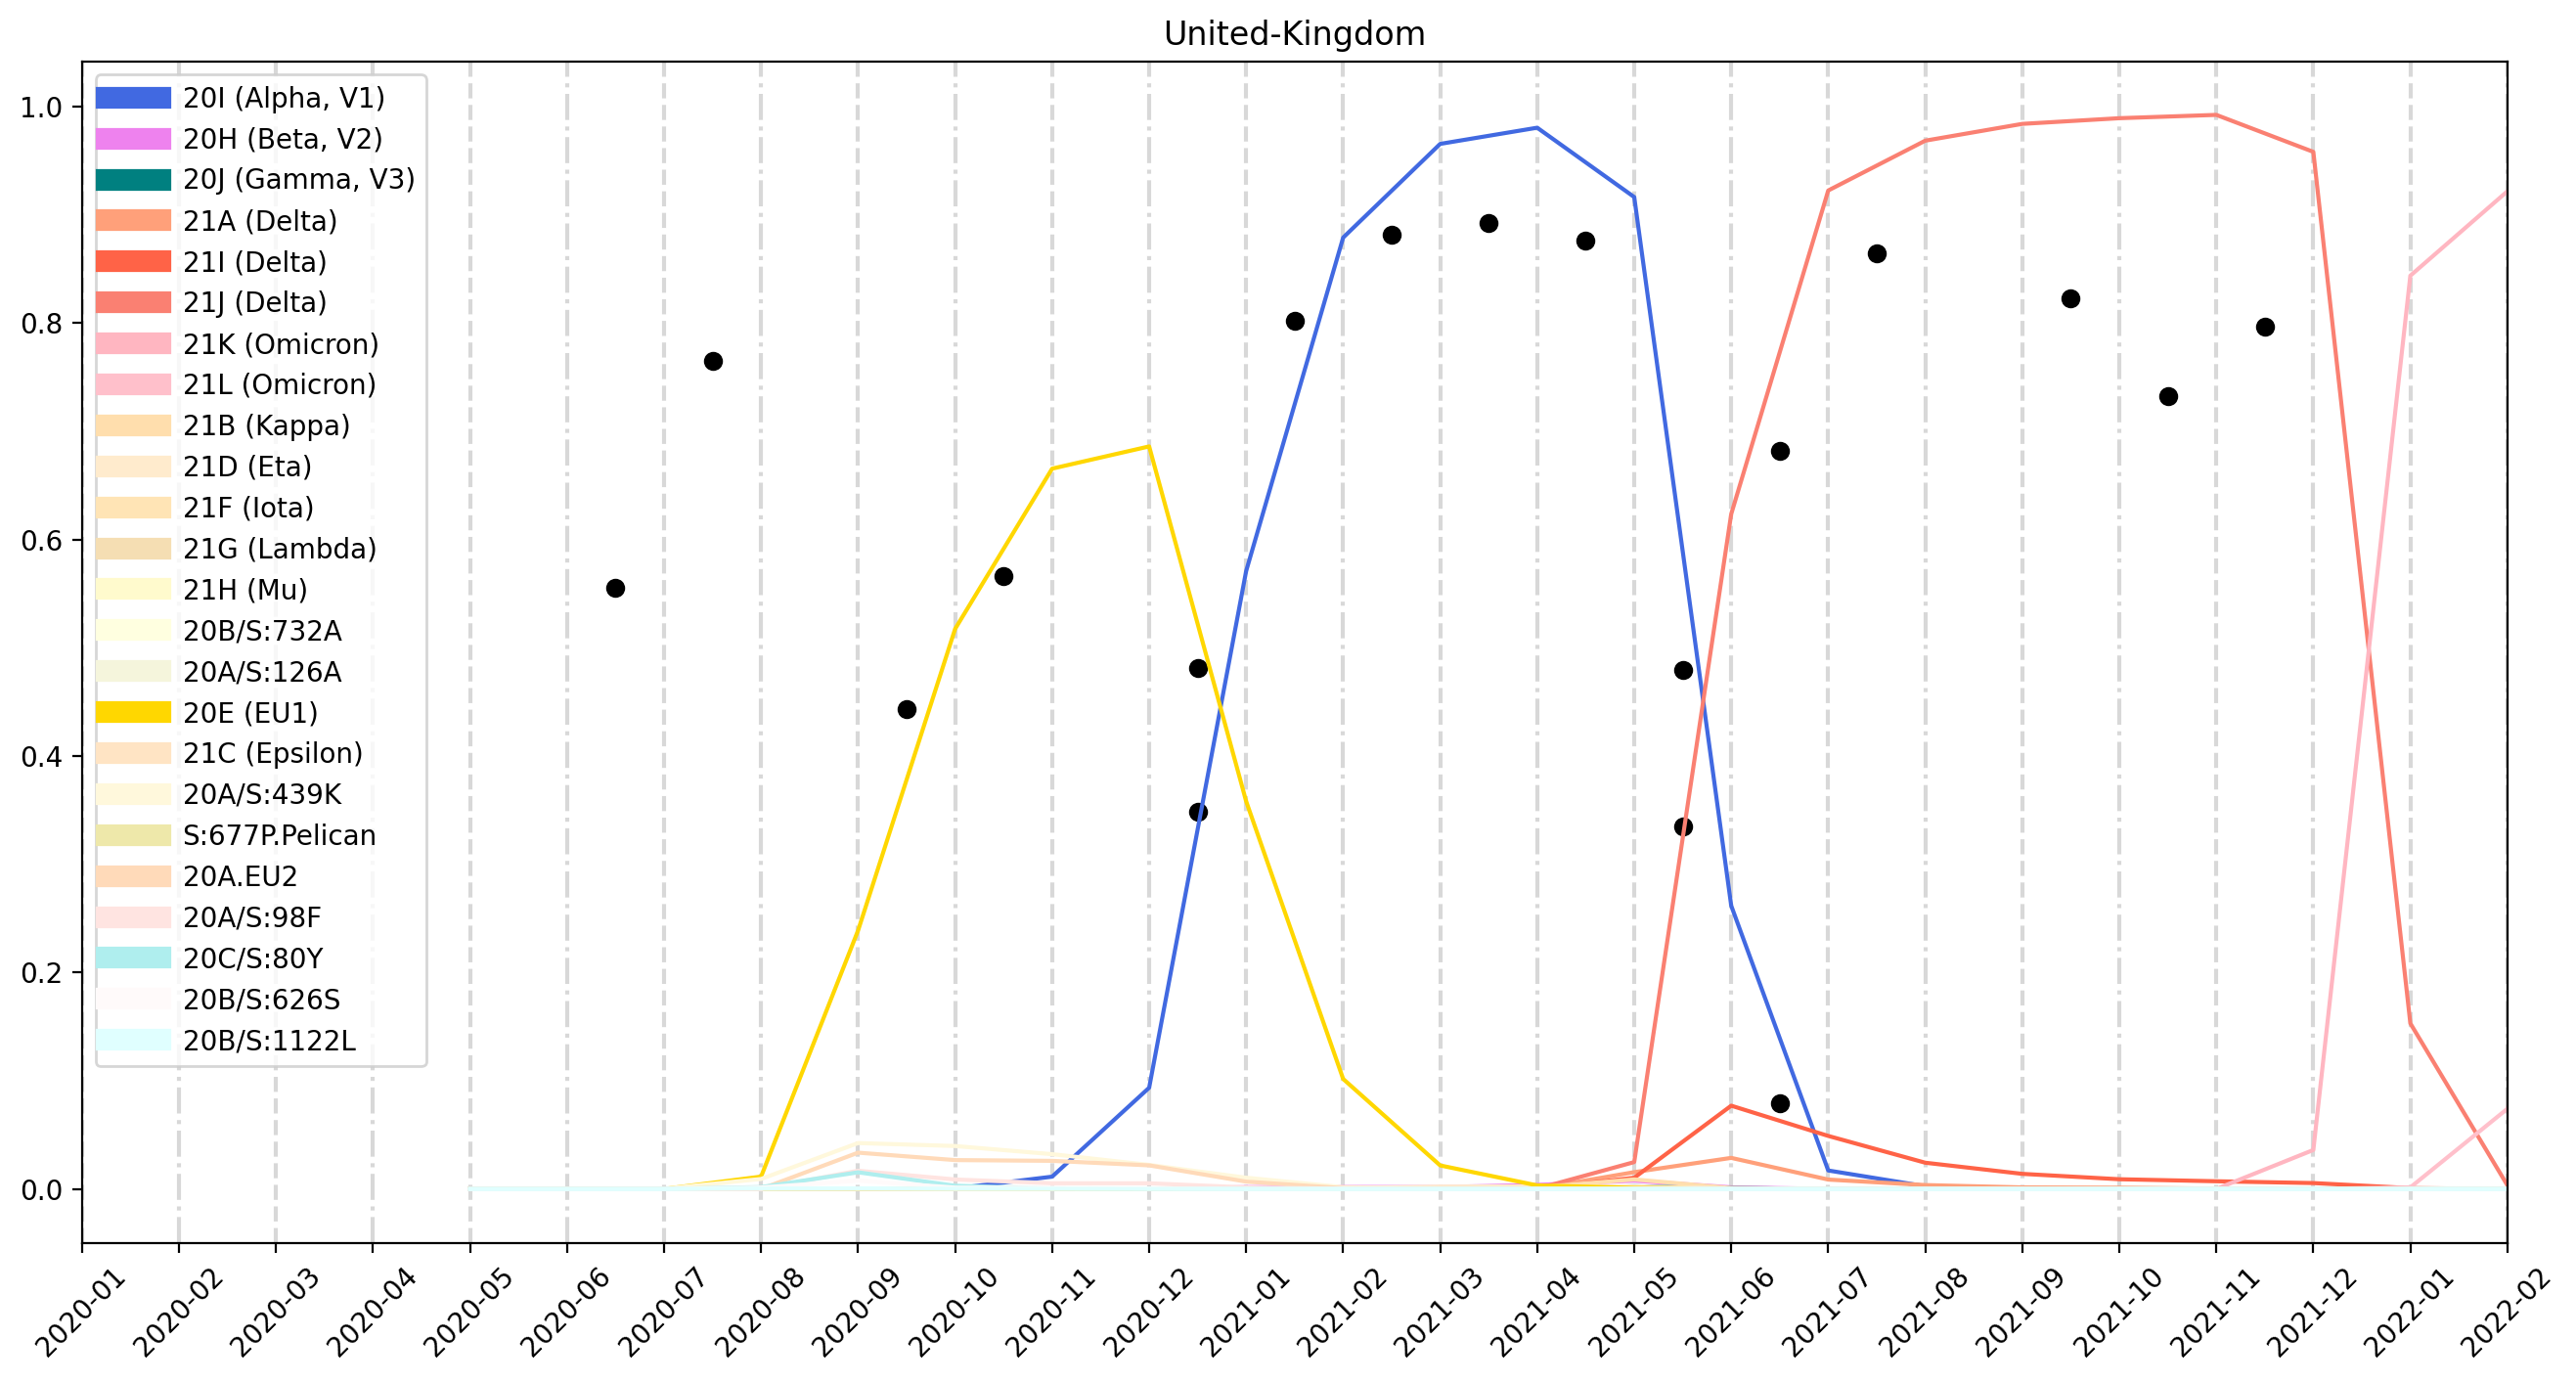

In [167]:
plot_predicted_frequencies(cases, parameter_data, "United-Kingdom", True)

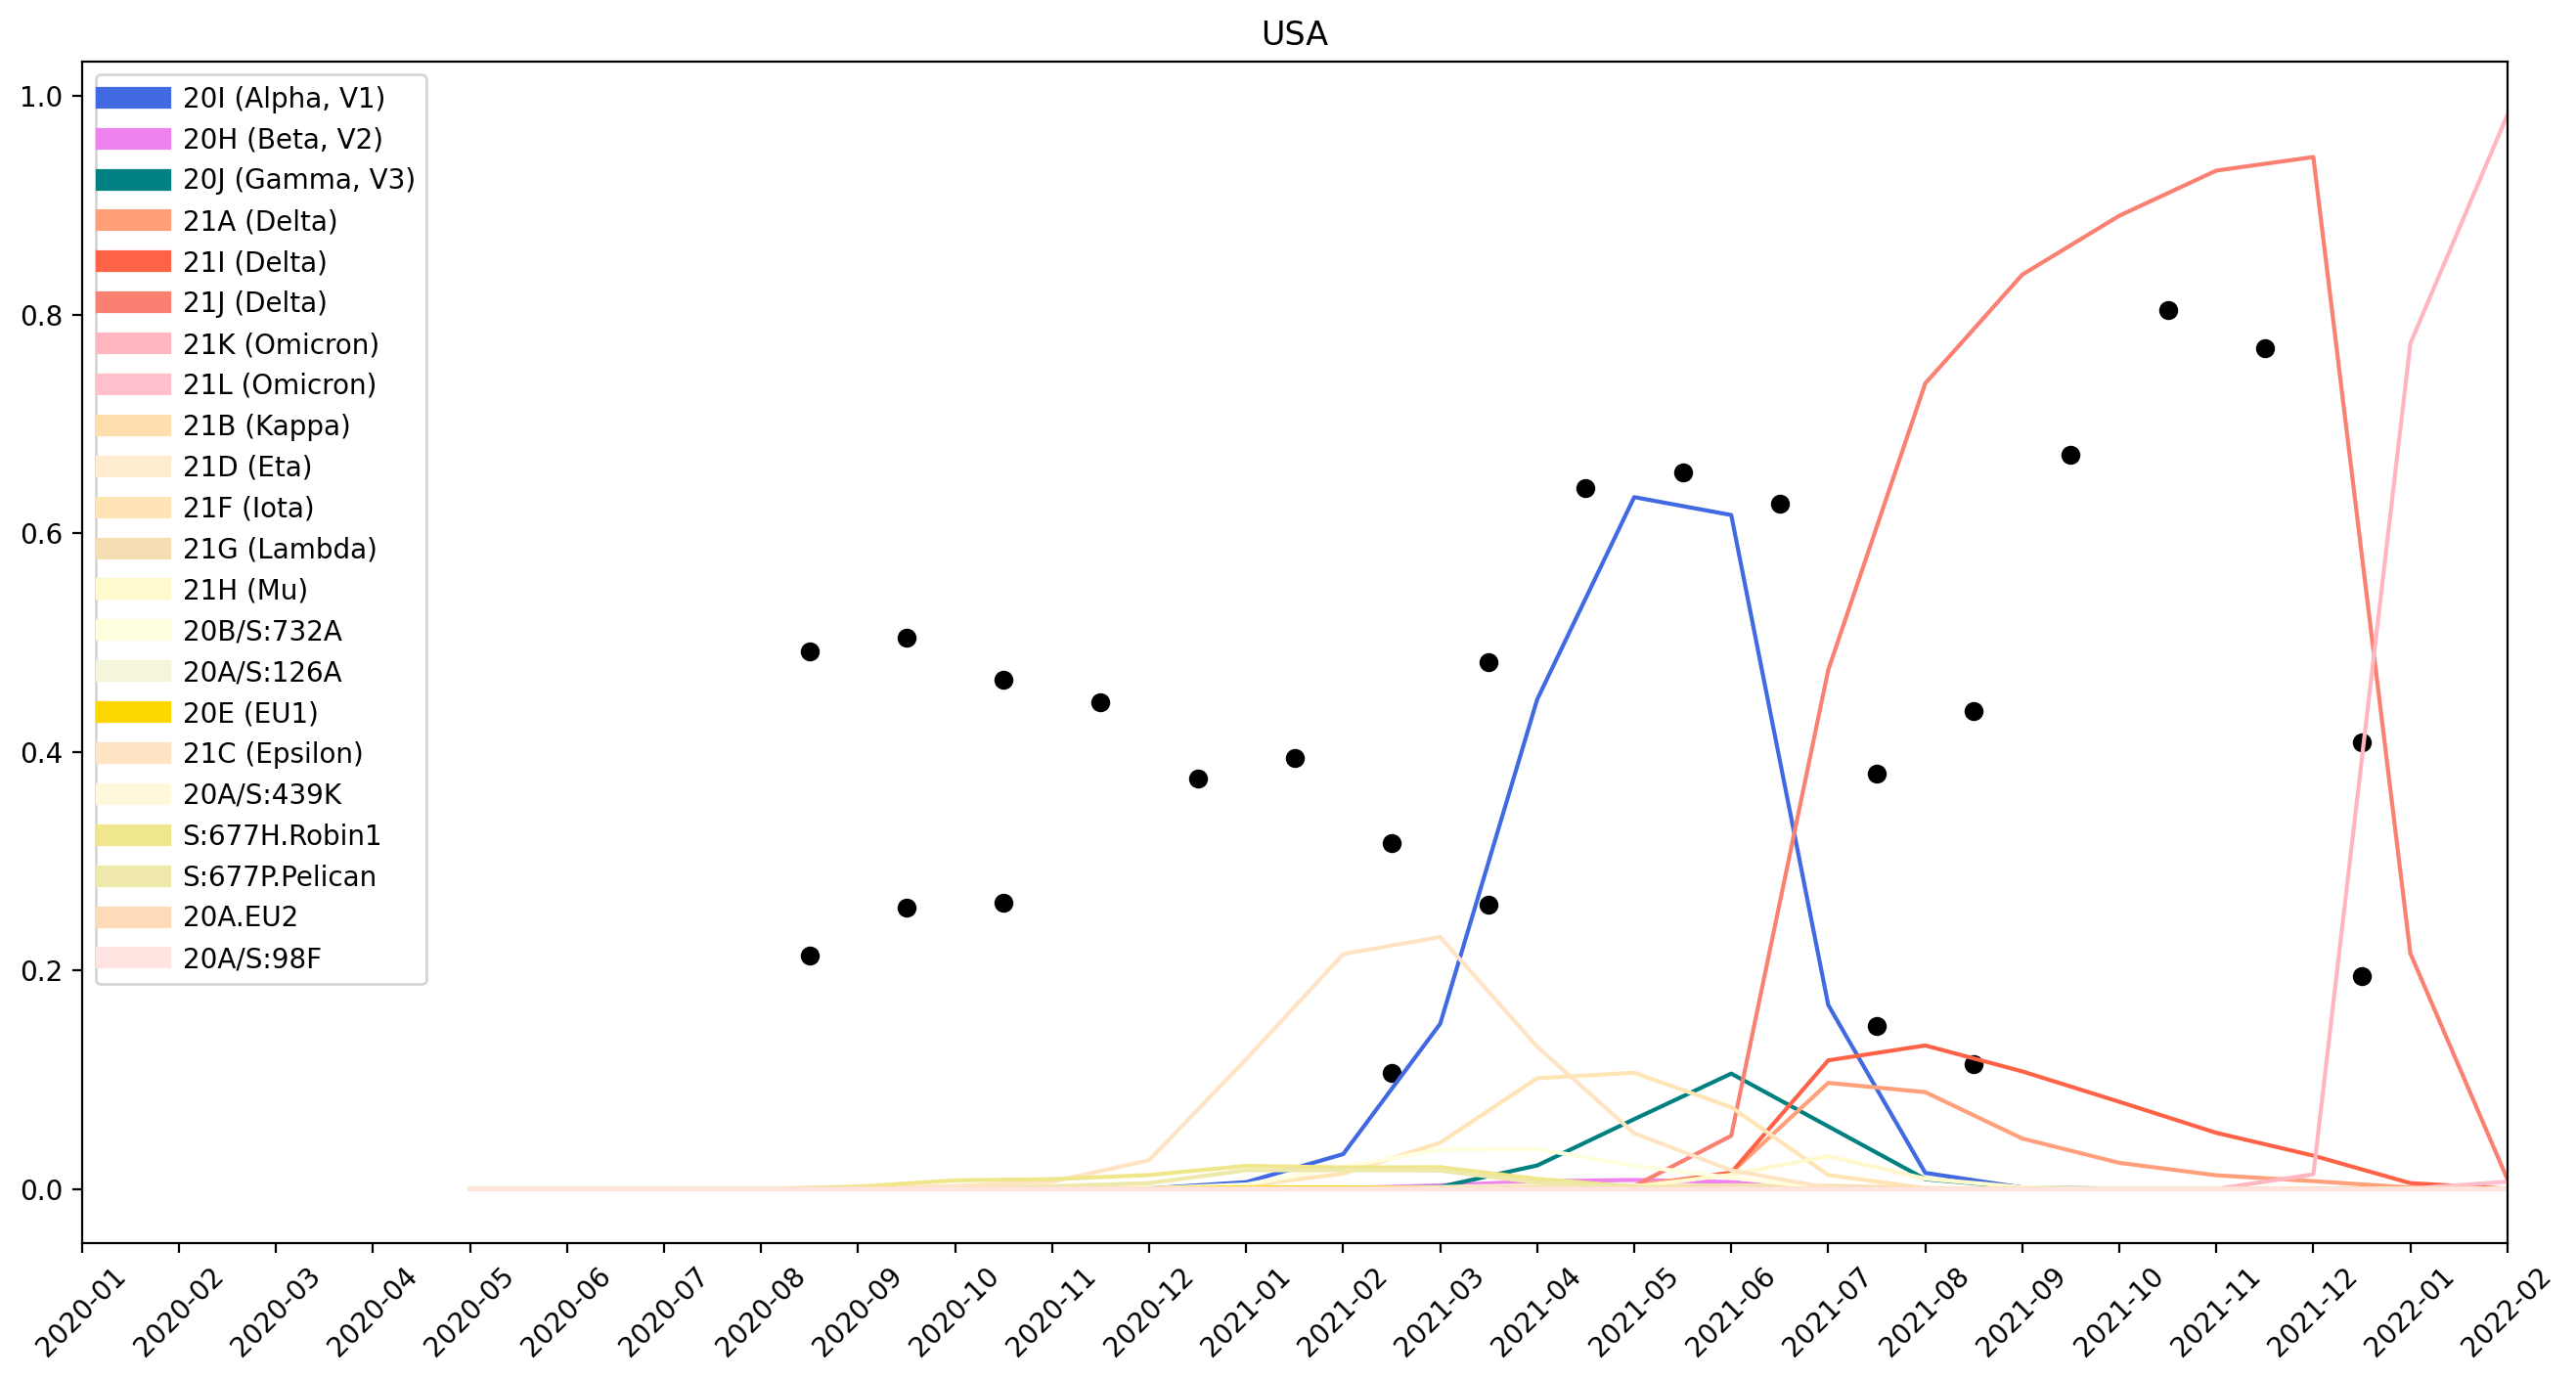

In [69]:
plot_predicted_frequencies(cases, parameter_data, "USA")